### COMP7409 Group Project

### Leveraging Clustering and Twitter Sentiment Analysis for Machine Learning-Driven Trading Strategies: A Deep Learning Approach

In [23]:
# Global variables for the project

# Download all online data to offline data (avoid crtical format change)
BACKUP_DATA = False

# Use Offline data
USE_BACKUP = True

# Path to this project
# data_folder = "D:\School\year2.1\ml_project\Algorithmic_Trading_Machine_Learning"
data_folder = input()

# default is 4
CLUSTERS_NUM = 6

# default is [30, 45, 55, 70]
CLUSTER_TARGET_RSI_VALUE = [20, 30, 40, 50, 60, 70]

## 1. Download/Load SP500 stocks prices data.

In [24]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

if USE_BACKUP is True:
    sp500 = pd.read_pickle("data1.pkl") 
else:
    sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]


if BACKUP_DATA is True:
    sp500.to_pickle("data1.pkl")

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

# end_date = '2024-10-01'
end_date = dt.date.today().strftime('%Y-%m-%d')

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*10)

if USE_BACKUP is True:
    df = pd.read_pickle("data7.pkl")
else:
    df = yf.download(tickers=symbols_list,
                     start=start_date,
                     end=end_date).stack()

if BACKUP_DATA is True:
    df.to_pickle("data7.pkl")

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

Price                              adj close       close        high  \
date                      ticker                                       
2016-10-06 00:00:00+00:00 A        44.459553   47.299999   47.430000   
                          AAPL     26.262880   28.472500   28.584999   
                          ABBV     44.508663   62.830002   63.209999   
                          ABT      37.119118   42.970001   43.049999   
                          ACGL     25.680000   25.680000   25.809999   
...                                      ...         ...         ...   
2024-10-03 00:00:00+00:00 XYL     133.059998  133.059998  134.089996   
                          YUM     137.210007  137.210007  138.660004   
                          ZBH     104.190002  104.190002  105.750000   
                          ZBRA    363.890015  363.890015  368.170013   
                          ZTS     190.990005  190.990005  192.330002   

Price                                    low        open       volume  
date                      ticker                                       
2016-10-06 00:00:00+00:00 A        46.880001   47.009998    1772800.0  
                          AAPL     28.282499   28.424999  115117200.0  
                          ABBV     62.560001   63.160000    4446100.0  
                          ABT      42.320000   42.689999    7250200.0  
                          ACGL     25.570000   25.719999    1463700.0  
...                                      ...         ...          ...  
2024-10-03 00:00:00+00:00 XYL     131.979996  134.089996    1007800.0  
                          YUM     137.199997  138.639999    1993400.0  
                          ZBH     103.820000  105.320000    1910100.0  
                          ZBRA    362.619995  365.989990     302400.0  
                          ZTS     190.000000  191.889999    1325000.0  

[988391 rows x 6 columns]

In [25]:
# We need to filter the data to have at least 20 observations per ticker as below we need to group by the ticker and filter the data at least 20 observations per ticker.
df = df.groupby(level="ticker").filter(lambda x: len(x) >= 20)

copy1 = df.copy()

## 2. Calculate features and technical indicators for each stock.

* Garman-Klass Volatility
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [26]:
df = copy1.copy()

df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

Price                              adj close       close        high  \
date                      ticker                                       
2016-10-06 00:00:00+00:00 A        44.459553   47.299999   47.430000   
                          AAPL     26.262880   28.472500   28.584999   
                          ABBV     44.508663   62.830002   63.209999   
                          ABT      37.119118   42.970001   43.049999   
                          ACGL     25.680000   25.680000   25.809999   
...                                      ...         ...         ...   
2024-10-03 00:00:00+00:00 XYL     133.059998  133.059998  134.089996   
                          YUM     137.210007  137.210007  138.660004   
                          ZBH     104.190002  104.190002  105.750000   
                          ZBRA    363.890015  363.890015  368.170013   
                          ZTS     190.990005  190.990005  192.330002   

Price                                    low        open       volume  \
date                      ticker                                        
2016-10-06 00:00:00+00:00 A        46.880001   47.009998    1772800.0   
                          AAPL     28.282499   28.424999  115117200.0   
                          ABBV     62.560001   63.160000    4446100.0   
                          ABT      42.320000   42.689999    7250200.0   
                          ACGL     25.570000   25.719999    1463700.0   
...                                      ...         ...          ...   
2024-10-03 00:00:00+00:00 XYL     131.979996  134.089996    1007800.0   
                          YUM     137.199997  138.639999    1993400.0   
                          ZBH     103.820000  105.320000    1910100.0   
                          ZBRA    362.619995  365.989990     302400.0   
                          ZTS     190.000000  191.889999    1325000.0   

Price                             garman_klass_vol        rsi    bb_low  \
date                      ticker                                          
2016-10-06 00:00:00+00:00 A              -0.001134        NaN       NaN   
                          AAPL           -0.002361        NaN       NaN   
                          ABBV           -0.047264        NaN       NaN   
                          ABT            -0.007407        NaN       NaN   
                          ACGL            0.000043        NaN       NaN   
...                                            ...        ...       ...   
2024-10-03 00:00:00+00:00 XYL             0.000103  49.330137  4.860378   
                          YUM             0.000014  55.382175  4.861648   
                          ZBH             0.000125  39.506848  4.652283   
                          ZBRA            0.000103  59.098207  5.781280   
                          ZTS             0.000066  53.496868  5.246796   

Price                               bb_mid   bb_high       atr      macd  \
date                      ticker                                           
2016-10-06 00:00:00+00:00 A            NaN       NaN       NaN       NaN   
                          AAPL         NaN       NaN       NaN       NaN   
                          ABBV         NaN       NaN       NaN       NaN   
                          ABT          NaN       NaN       NaN       NaN   
                          ACGL         NaN       NaN       NaN       NaN   
...                                    ...       ...       ...       ...   
2024-10-03 00:00:00+00:00 XYL     4.895486  4.930595  0.592308  0.069804   
                          YUM     4.908749  4.955849  0.706729  0.705785   
                          ZBH     4.674293  4.696304 -0.859243 -0.346073   
                          ZBRA    5.870433  5.959586 -0.018684  0.941680   
                          ZTS     5.267334  5.287872  0.439062  0.603249   

Price                             dollar_volume  
date                      ticker                 
2016-10-06 00:00:00+00:00 A           78.817895 

## 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

* To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [27]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close       atr  \
date                      ticker                                        
2016-11-30 00:00:00+00:00 A          107.395372   41.338917 -1.185125   
                          AAPL      3498.943100   25.616610 -1.275378   
                          ABBV       400.728792   43.467728 -0.788085   
                          ABT        293.371471   33.095367 -1.215167   
                          ACGL        28.556549   27.573334 -1.222271   
...                                         ...         ...       ...   
2024-10-31 00:00:00+00:00 KVUE       304.631208   22.270000 -0.747019   
                          VLTO       151.274930  111.309998 -0.275845   
                          GEV        592.313106  254.679993  0.218030   
                          SOLV        56.336286   67.260002 -0.475992   
                          SW         168.059770   46.630001 -0.751794   

                                   bb_high    bb_low    bb_mid  \
date                      ticker                                 
2016-11-30 00:00:00+00:00 A       3.811355  3.726190  3.768773   
                          AAPL    3.306472  3.248344  3.277408   
                          ABBV    3.861499  3.713227  3.787363   
                          ABT     3.598063  3.525170  3.561617   
                          ACGL    3.363047  3.285027  3.324037   
...                                    ...       ...       ...   
2024-10-31 00:00:00+00:00 KVUE    3.201702  3.157950  3.179826   
                          VLTO    4.727888  4.690679  4.709284   
                          GEV     5.640480  5.290900  5.465690   
                          SOLV    4.303533  4.200117  4.251825   
                          SW      3.952002  3.784889  3.868445   

                                  garman_klass_vol      macd        rsi  
date                      ticker                                         
2016-11-30 00:00:00+00:00 A              -0.002250 -0.315312  42.749594  
                          AAPL           -0.002666 -0.399385  45.737424  
                          ABBV           -0.046891 -0.300314  50.228188  
                          ABT            -0.009455 -0.597104  37.725314  
                          ACGL            0.000048  0.038938  67.136827  
...                                            ...       ...        ...  
2024-10-31 00:00:00+00:00 KVUE            0.000056  0.828224  51.701951  
                          VLTO            0.000053 -0.362720  57.545482  
                          GEV             0.000298  1.964759  72.811211  
                          SOLV            0.000140  0.616428  54.556170  
                          SW              0.000089  0.866696  50.795580  

[47183 rows x 9 columns]

* Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [28]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close       atr   bb_high    bb_low  \
date                      ticker                                             
2017-10-31 00:00:00+00:00 AAPL     39.667984 -1.172459  3.687347  3.593605   
                          ABBV     66.876808  0.159929  4.280405  4.187696   
                          ABT      48.237461 -1.282547  3.934519  3.887385   
                          ACN     128.834686 -1.242691  4.877691  4.798335   
                          ADBE    175.160004 -1.235235  5.226825  4.951759   
...                                      ...       ...       ...       ...   
2024-10-31 00:00:00+00:00 UBER     72.940002  0.659954  4.378695  4.232161   
                          CRWD    283.750000  0.506559  5.725468  5.492466   
                          PLTR     39.240002  0.508001  3.714733  3.516882   
                          ABNB    125.290001 -1.021836  4.918369  4.729073   
                          KVUE     22.270000 -0.747019  3.201702  3.157950   

                                    bb_mid  garman_klass_vol      macd  \
date                      ticker                                         
2017-10-31 00:00:00+00:00 AAPL    3.640476         -0.001105 -0.100619   
                          ABBV    4.234051         -0.036142  0.322639   
                          ABT     3.910952         -0.005677  0.222083   
                          ACN     4.838013         -0.004274  0.291822   
                          ADBE    5.089292          0.000067  0.557369   
...                                    ...               ...       ...   
2024-10-31 00:00:00+00:00 UBER    4.305428          0.000152  0.554901   
                          CRWD    5.608967          0.000325  0.442405   
                          PLTR    3.615807          0.000413  1.561409   
                          ABNB    4.823721          0.000114  0.387978   
                          KVUE    3.179826          0.000056  0.828224   

                                        rsi  
date                      ticker             
2017-10-31 00:00:00+00:00 AAPL    69.196692  
                          ABBV    55.247859  
                          ABT     53.844892  
                          ACN     69.365138  
                          ADBE    70.089319  
...                                     ...  
2024-10-31 00:00:00+00:00 UBER    51.162038  
                          CRWD    53.417823  
                          PLTR    71.660101  
                          ABNB    50.226788  
                          KVUE    51.701951  

[12665 rows x 8 columns]

## 4. Calculate Monthly Returns for different time horizons as features.

* To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [29]:
def calculate_returns(df):
    outlier_cutoff = 0.005
    lags = [1, 2, 3, 6, 9, 12]
    for lag in lags:
        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df


data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

copy1 = data.copy()

data

adj close       atr   bb_high    bb_low  \
date                      ticker                                             
2018-10-31 00:00:00+00:00 AAPL     52.135612 -0.535302  4.014081  3.937351   
                          ABBV     59.937759  0.315719  4.343227  4.099873   
                          ABT      62.445824 -0.219238  4.192526  4.108511   
                          ACN     145.218887 -0.437182  5.059567  4.930141   
                          ADBE    245.759995  0.205986  5.588203  5.452778   
...                                      ...       ...       ...       ...   
2024-10-31 00:00:00+00:00 MRNA     61.070000 -0.645574  4.383355  4.090040   
                          UBER     72.940002  0.659954  4.378695  4.232161   
                          CRWD    283.750000  0.506559  5.725468  5.492466   
                          PLTR     39.240002  0.508001  3.714733  3.516882   
                          ABNB    125.290001 -1.021836  4.918369  4.729073   

                                    bb_mid  garman_klass_vol      macd  \
date                      ticker                                         
2018-10-31 00:00:00+00:00 AAPL    3.975716         -0.000440 -0.453664   
                          ABBV    4.221550         -0.033812 -1.780804   
                          ABT     4.150519         -0.003318 -0.506696   
                          ACN     4.994854         -0.001825 -0.892427   
                          ADBE    5.520491          0.000288 -0.672910   
...                                    ...               ...       ...   
2024-10-31 00:00:00+00:00 MRNA    4.236698          0.000274 -0.632793   
                          UBER    4.305428          0.000152  0.554901   
                          CRWD    5.608967          0.000325  0.442405   
                          PLTR    3.615807          0.000413  1.561409   
                          ABNB    4.823721          0.000114  0.387978   

                                        rsi  return_1m  return_2m  return_3m  \
date                      ticker                                               
2018-10-31 00:00:00+00:00 AAPL    50.232911  -0.030478  -0.019453   0.048955   
                          ABBV    30.334161  -0.168082  -0.089524  -0.051576   
                          ABT     51.539041  -0.056387   0.017673   0.018393   
                          ACN     44.756096  -0.065449  -0.030053  -0.000564   
                          ADBE    46.518480  -0.089609  -0.034267   0.001469   
...                                     ...        ...        ...        ...   
2024-10-31 00:00:00+00:00 MRNA    30.083390  -0.086189  -0.111733  -0.199872   
                          UBER    51.162038  -0.029537  -0.001300   0.042004   
                          CRWD    53.417823   0.011695   0.011600   0.069484   
                          PLTR    71.660101   0.054839   0.116470   0.134260   
                          ABNB    50.226788  -0.011986   0.033453  -0.035316   

                                  return_6m  return_9m  return_12m  
date                      ticker                                    
2018-10-31 00:00:00+00:00 AAPL     0.049216   0.031518    0.023037  
                          ABBV    -0.031893  -0.035903   -0.009087  
                          ABT      0.030307   0.013075    0.021747  
                          ACN      0.008483  -0.000163    0.010026  
                          ADBE     0.017396   0.023294    0.028623  
...                                     ...        ...         ...  
2024-10-31 00:00:00+00:00 MRNA    -0.093846  -0.054418   -0.018018  
                          UBER     0.016112   0.012421    0.044455  
                          CRWD    -0.005072  -0.003369    0.040225  
                          PLTR     0.101497   0.104127    0.084648  
                          ABNB    -0.038500  -0.015452    0.004802  

[10506 rows x 14 columns]

## 5. Download Fama-French Factors and Calculate Rolling Factor Betas.

* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [30]:
data = copy1.copy()

if USE_BACKUP is True:
    factor_data = pd.read_pickle("data2.pkl")
else:
    # Fetch factor data
    factor_data = web.DataReader(
        "F-F_Research_Data_5_Factors_2x3", "famafrench", start="2010"
    )[0].drop("RF", axis=1)


if BACKUP_DATA is True:
    factor_data.to_pickle("data2.pkl")

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample("M").last().div(100)
factor_data.index.name = "date"

# Remove timezone information from factor_data index
factor_data.index = factor_data.index.tz_localize(None)

# Remove timezone information from the 'date' level in data's MultiIndex
data.index = data.index.set_levels(data.index.levels[0].tz_localize(None), level=0)

# Proceed with the join operation
factor_data = factor_data.join(data["return_1m"]).sort_index()

copy2 = factor_data.copy()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-10-31 AAPL   -0.0768 -0.0445  0.0340  0.0095  0.0358  -0.030478
           ABBV   -0.0768 -0.0445  0.0340  0.0095  0.0358  -0.168082
           ABT    -0.0768 -0.0445  0.0340  0.0095  0.0358  -0.056387
           ACN    -0.0768 -0.0445  0.0340  0.0095  0.0358  -0.065449
           ADBE   -0.0768 -0.0445  0.0340  0.0095  0.0358  -0.089609
...                   ...     ...     ...     ...     ...        ...
2024-08-31 VRTX    0.0161 -0.0365 -0.0112  0.0085  0.0086   0.000343
           VZ      0.0161 -0.0365 -0.0112  0.0085  0.0086   0.031096
           WFC     0.0161 -0.0365 -0.0112  0.0085  0.0086  -0.007134
           WMT     0.0161 -0.0365 -0.0112  0.0085  0.0086   0.122238
           XOM     0.0161 -0.0365 -0.0112  0.0085  0.0086   0.002526

[10222 rows x 6 columns]

* Filter out stocks with less than 10 months of data.

In [31]:
factor_data = copy2.copy()

observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-10-31 AAPL   -0.0768 -0.0445  0.0340  0.0095  0.0358  -0.030478
           ABBV   -0.0768 -0.0445  0.0340  0.0095  0.0358  -0.168082
           ABT    -0.0768 -0.0445  0.0340  0.0095  0.0358  -0.056387
           ACN    -0.0768 -0.0445  0.0340  0.0095  0.0358  -0.065449
           ADBE   -0.0768 -0.0445  0.0340  0.0095  0.0358  -0.089609
...                   ...     ...     ...     ...     ...        ...
2024-08-31 VRTX    0.0161 -0.0365 -0.0112  0.0085  0.0086   0.000343
           VZ      0.0161 -0.0365 -0.0112  0.0085  0.0086   0.031096
           WFC     0.0161 -0.0365 -0.0112  0.0085  0.0086  -0.007134
           WMT     0.0161 -0.0365 -0.0112  0.0085  0.0086   0.122238
           XOM     0.0161 -0.0365 -0.0112  0.0085  0.0086   0.002526

[10186 rows x 6 columns]

* Calculate Rolling Factor Betas.

In [32]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-10-31 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-08-31 VRTX    0.598571  0.650479 -0.306588  0.838833 -0.041707
           VZ      0.661296 -0.844122  0.556700  0.127529 -0.315554
           WFC     1.111631 -0.113496  1.196615 -0.777167 -0.654384
           WMT     0.575124 -0.029244 -0.086743  1.055584 -0.007052
           XOM     0.657494 -0.074608  0.395617  0.822290  0.828980

[10186 rows x 5 columns]

* Join the rolling factors data to the main features dataframe.

In [33]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

copy3 = data.copy()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10281 entries, (Timestamp('2018-10-31 00:00:00'), 'AAPL') to (Timestamp('2024-10-31 00:00:00'), 'CRWD')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               10281 non-null  float64
 1   bb_high           10281 non-null  float64
 2   bb_low            10281 non-null  float64
 3   bb_mid            10281 non-null  float64
 4   garman_klass_vol  10281 non-null  float64
 5   macd              10281 non-null  float64
 6   rsi               10281 non-null  float64
 7   return_1m         10281 non-null  float64
 8   return_2m         10281 non-null  float64
 9   return_3m         10281 non-null  float64
 10  return_6m         10281 non-null  float64
 11  return_9m         10281 non-null  float64
 12  return_12m        10281 non-null  float64
 13  Mkt-RF            10281 non-null  float64
 14  SMB               10281 non-null  float64
 15  HML      

### At this point we have to decide on what ML model and approach to use for predictions etc.


## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

### K-Means Clustering
* You may want to initialize predefined centroids for each cluster based on your research.

* For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

* Then we will pre-define our centroids for each cluster.

In [34]:
data = copy3.copy()

# The order must be followed, as the clustering is based on index position

desired_column_order = [
    "atr",
    "bb_high",
    "bb_low",
    "bb_mid",
    "garman_klass_vol",
    "macd",
    "rsi",
    "return_1m",
    "return_2m",
    "return_3m",
    "return_6m",
    "return_9m",
    "return_12m",
    "Mkt-RF",
    "SMB",
    "HML",
    "RMW",
    "CMA",
]

# Reorder the columns in your DataFrame to match the desired order
data = data[desired_column_order]

# Now, the DataFrame `df` should have the same order of columns as the original one.
data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2018-10-31 AAPL   -0.535302  4.014081  3.937351  3.975716         -0.000440   
           ABBV    0.315719  4.343227  4.099873  4.221550         -0.033812   
           ABT    -0.219238  4.192526  4.108511  4.150519         -0.003318   
           ACN    -0.437182  5.059567  4.930141  4.994854         -0.001825   
           ADBE    0.205986  5.588203  5.452778  5.520491          0.000288   
...                     ...       ...       ...       ...               ...   
2024-10-31 WMT     1.608096  4.420834  4.358117  4.389475          0.000040   
           XOM     1.250888  4.812363  4.696001  4.754182          0.000156   
           MRNA   -0.645574  4.383355  4.090040  4.236698          0.000274   
           UBER    0.659954  4.378695  4.232161  4.305428          0.000152   
           CRWD    0.506559  5.725468  5.492466  5.608967          0.000325   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2018-10-31 AAPL   -0.453664  50.232911  -0.030478  -0.019453   0.048955   
           ABBV   -1.780804  30.334161  -0.168082  -0.089524  -0.051576   
           ABT    -0.506696  51.539041  -0.056387   0.017673   0.018393   
           ACN    -0.892427  44.756096  -0.065449  -0.030053  -0.000564   
           ADBE   -0.672910  46.518480  -0.089609  -0.034267   0.001469   
...                     ...        ...        ...        ...        ...   
2024-10-31 WMT     2.278203  63.139381  -0.003963   0.020507   0.055259   
           XOM     0.939620  61.874866   0.045726   0.019481   0.013798   
           MRNA   -0.632793  30.083390  -0.086189  -0.111733  -0.199872   
           UBER    0.554901  51.162038  -0.029537  -0.001300   0.042004   
           CRWD    0.442405  53.417823   0.011695   0.011600   0.069484   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-10-31 AAPL     0.049216   0.031518    0.023037  1.308384 -0.284239   
           ABBV    -0.031893  -0.035903   -0.009087  0.514009  0.384370   
           ABT      0.030307   0.013075    0.021747  0.769063 -0.073327   
           ACN      0.008483  -0.000163    0.010026  1.210478 -0.204158   
           ADBE     0.017396   0.023294    0.028623  1.288116 -0.527918   
...                      ...        ...         ...       ...       ...   
2024-10-31 WMT      0.052401   0.044082    0.034166  0.626498 -0.355778   
           XOM      0.008688   0.022612    0.015215  1.036376  0.102749   
           MRNA    -0.093846  -0.054418   -0.018018  1.352402  0.955077   
           UBER     0.016112   0.012421    0.044455  1.260525  0.603084   
           CRWD    -0.005072  -0.003369    0.040225  0.654093 -1.534015   

                        HML       RMW       CMA  
date       ticker                                
2018-10-31 AAPL   -0.628617  0.376332  0.559993  
           ABBV   -0.174569  0.463264  0.524854  
           ABT    -0.435420  0.204034  0.946884  
           ACN    -0.237568  0.347237  0.040598  
           ADBE   -0.254765  0.299691 -0.447282  
...                     ...       ...       ...  
2024-10-31 WMT    -0.368323  0.177524  0.650668  
           XOM     0.872941 -0.496406  0.389865  
           MRNA   -0.882331  1.221036  1.051589  
           UBER   -0.325542 -1.898969 -0.410352  
           CRWD    0.113036 -2.922695 -1.664094  

[10281 rows x 18 columns]

In [35]:
from sklearn.cluster import KMeans

def get_clusters(df):
    df["cluster"] = (
        KMeans(n_clusters=CLUSTERS_NUM, random_state=0, init="random").fit(df).labels_
    )
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

model_train_data = data

data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2018-10-31 AAPL   -0.535302  4.014081  3.937351  3.975716         -0.000440   
           ABBV    0.315719  4.343227  4.099873  4.221550         -0.033812   
           ABT    -0.219238  4.192526  4.108511  4.150519         -0.003318   
           ACN    -0.437182  5.059567  4.930141  4.994854         -0.001825   
           ADBE    0.205986  5.588203  5.452778  5.520491          0.000288   
...                     ...       ...       ...       ...               ...   
2024-10-31 WMT     1.608096  4.420834  4.358117  4.389475          0.000040   
           XOM     1.250888  4.812363  4.696001  4.754182          0.000156   
           MRNA   -0.645574  4.383355  4.090040  4.236698          0.000274   
           UBER    0.659954  4.378695  4.232161  4.305428          0.000152   
           CRWD    0.506559  5.725468  5.492466  5.608967          0.000325   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2018-10-31 AAPL   -0.453664  50.232911  -0.030478  -0.019453   0.048955   
           ABBV   -1.780804  30.334161  -0.168082  -0.089524  -0.051576   
           ABT    -0.506696  51.539041  -0.056387   0.017673   0.018393   
           ACN    -0.892427  44.756096  -0.065449  -0.030053  -0.000564   
           ADBE   -0.672910  46.518480  -0.089609  -0.034267   0.001469   
...                     ...        ...        ...        ...        ...   
2024-10-31 WMT     2.278203  63.139381  -0.003963   0.020507   0.055259   
           XOM     0.939620  61.874866   0.045726   0.019481   0.013798   
           MRNA   -0.632793  30.083390  -0.086189  -0.111733  -0.199872   
           UBER    0.554901  51.162038  -0.029537  -0.001300   0.042004   
           CRWD    0.442405  53.417823   0.011695   0.011600   0.069484   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-10-31 AAPL     0.049216   0.031518    0.023037  1.308384 -0.284239   
           ABBV    -0.031893  -0.035903   -0.009087  0.514009  0.384370   
           ABT      0.030307   0.013075    0.021747  0.769063 -0.073327   
           ACN      0.008483  -0.000163    0.010026  1.210478 -0.204158   
           ADBE     0.017396   0.023294    0.028623  1.288116 -0.527918   
...                      ...        ...         ...       ...       ...   
2024-10-31 WMT      0.052401   0.044082    0.034166  0.626498 -0.355778   
           XOM      0.008688   0.022612    0.015215  1.036376  0.102749   
           MRNA    -0.093846  -0.054418   -0.018018  1.352402  0.955077   
           UBER     0.016112   0.012421    0.044455  1.260525  0.603084   
           CRWD    -0.005072  -0.003369    0.040225  0.654093 -1.534015   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-10-31 AAPL   -0.628617  0.376332  0.559993        5  
           ABBV   -0.174569  0.463264  0.524854        1  
           ABT    -0.435420  0.204034  0.946884        5  
           ACN    -0.237568  0.347237  0.040598        2  
           ADBE   -0.254765  0.299691 -0.447282        2  
...                     ...       ...       ...      ...  
2024-10-31 WMT    -0.368323  0.177524  0.650668        4  
           XOM     0.872941 -0.496406  0.389865        4  
           MRNA   -0.882331  1.221036  1.051589        2  
           UBER   -0.325542 -1.898969 -0.410352        5  
           CRWD    0.113036 -2.922695 -1.664094        0  

[10281 rows x 19 columns]

In [36]:
colorList = ['red', 'green', 'blue', 'black', 'yellow', 'orange', 'purple', 'pink', 'brown', 'gray']

def plot_clusters(data):
    for i in range(CLUSTERS_NUM):
        cluster = data[data['cluster'] == i]
        plt.scatter(cluster.iloc[:, 0], cluster.iloc[:, 6], color=colorList[i], label=f'cluster {i}')

    plt.legend()
    plt.show()
    return


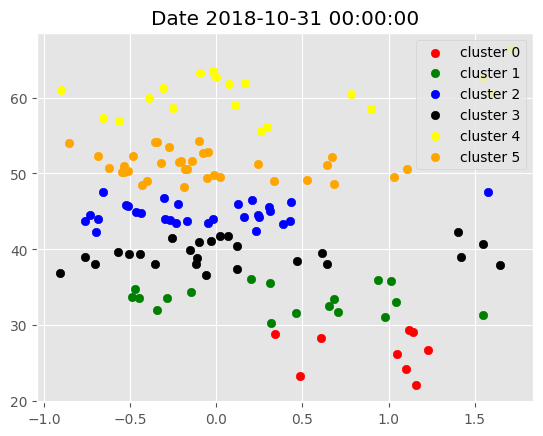

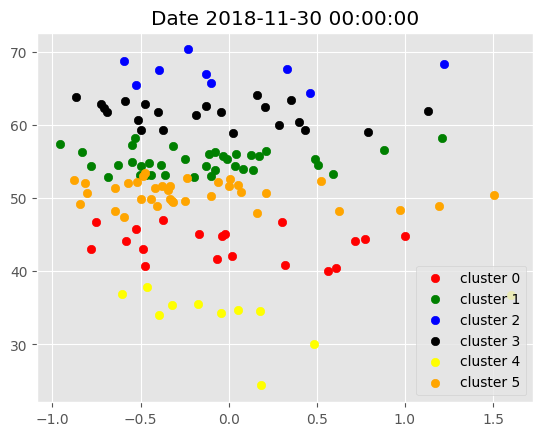

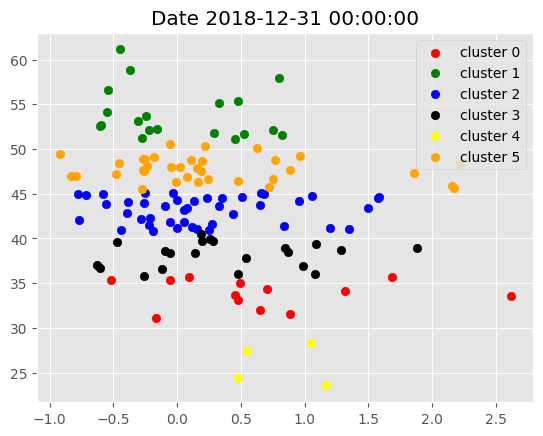

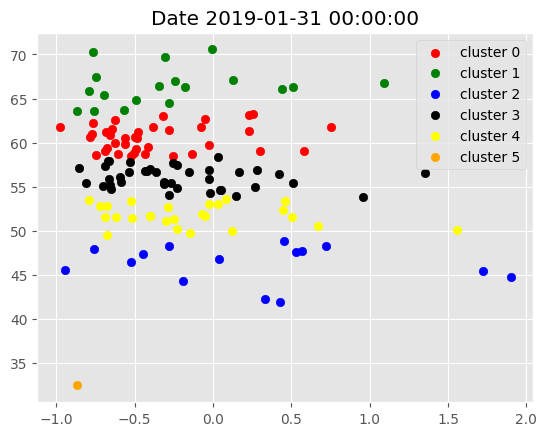

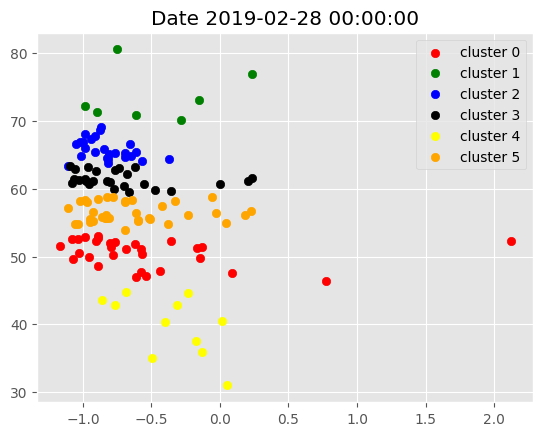

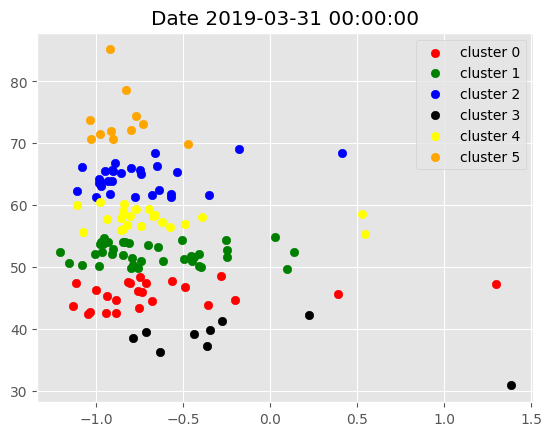

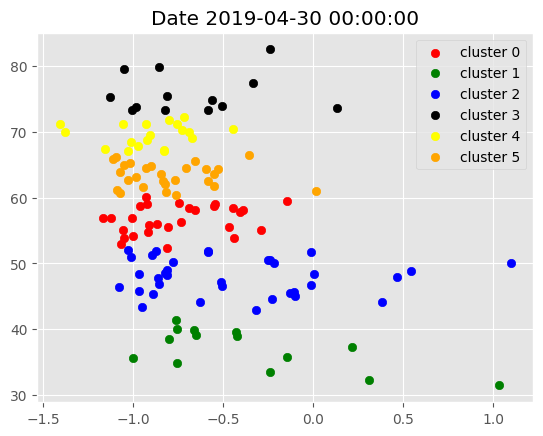

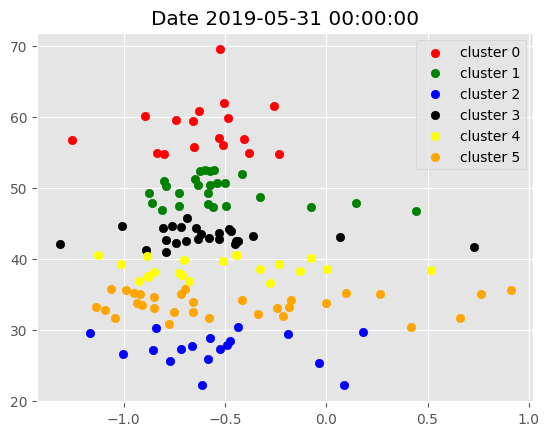

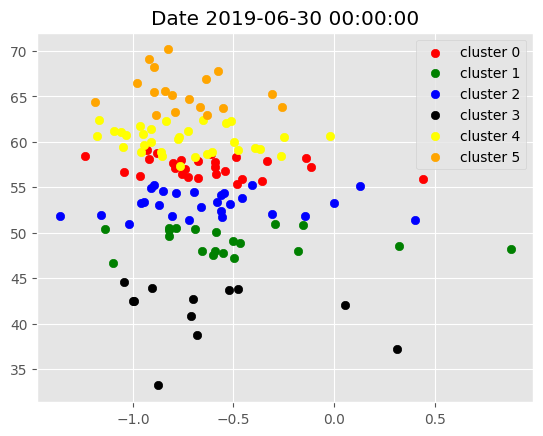

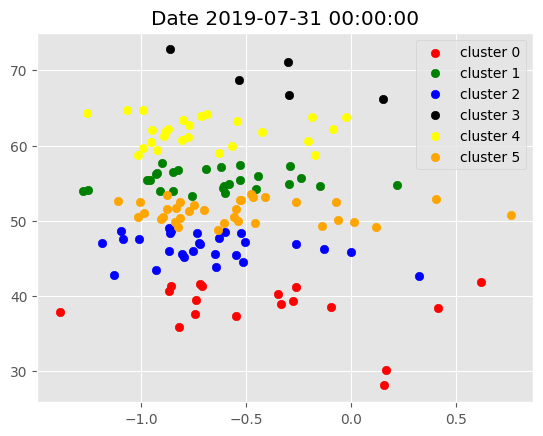

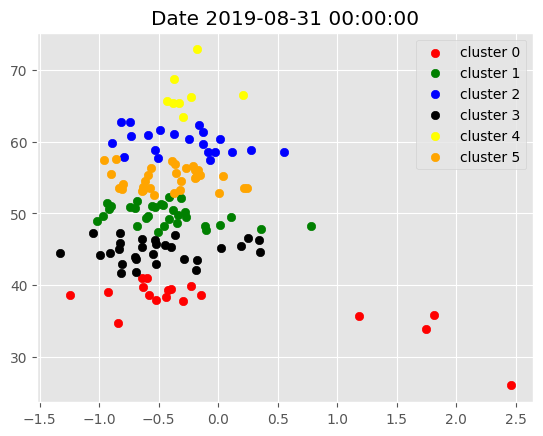

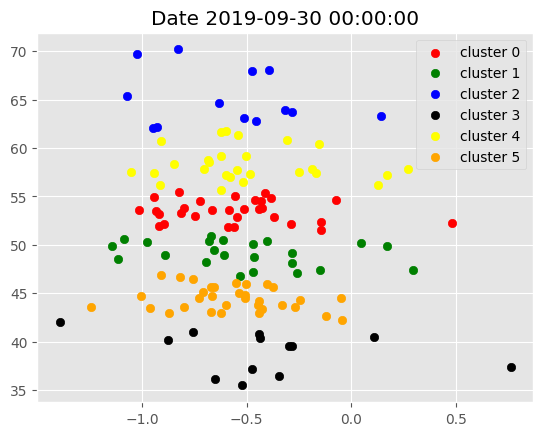

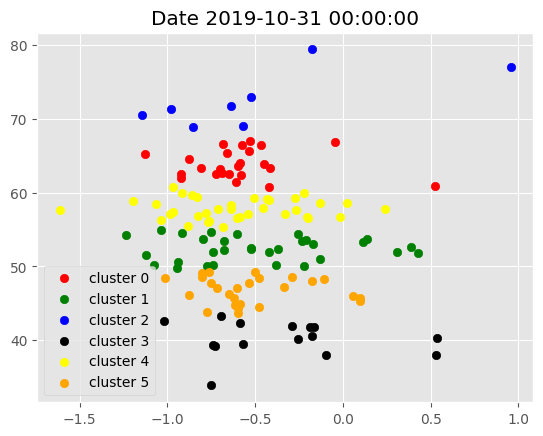

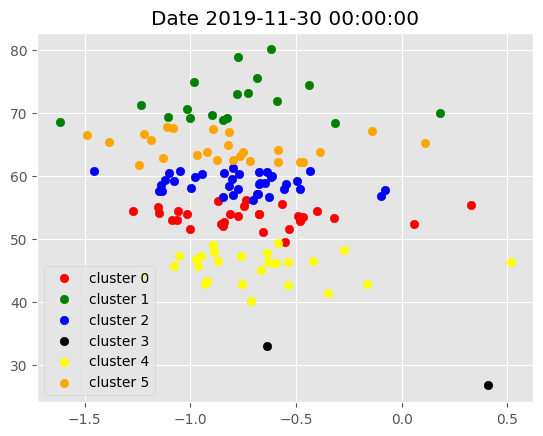

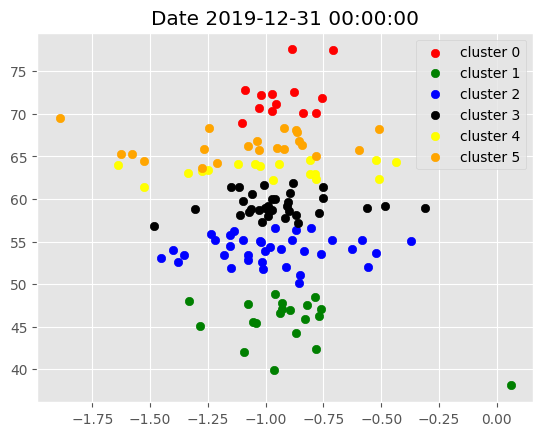

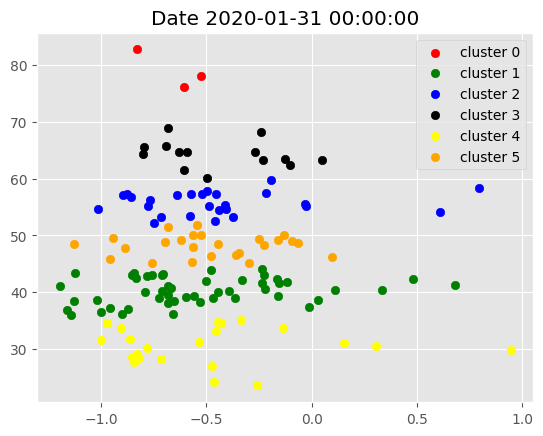

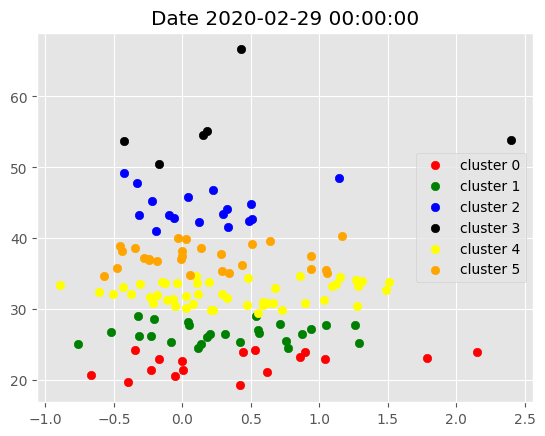

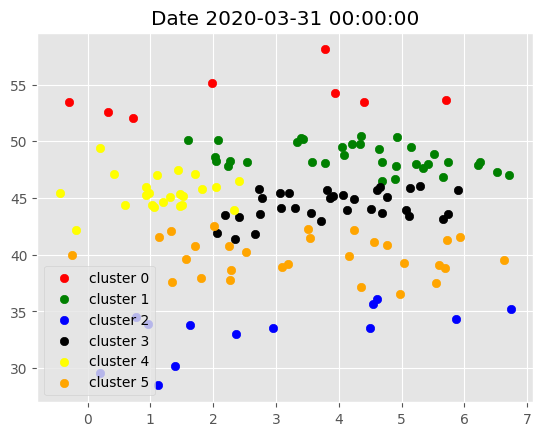

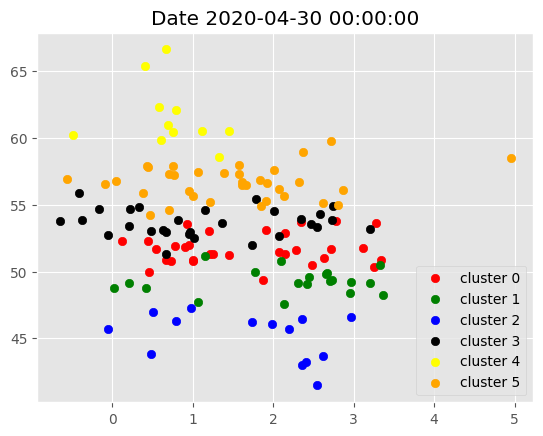

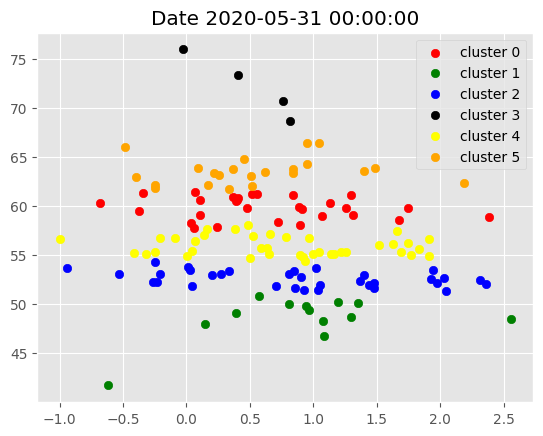

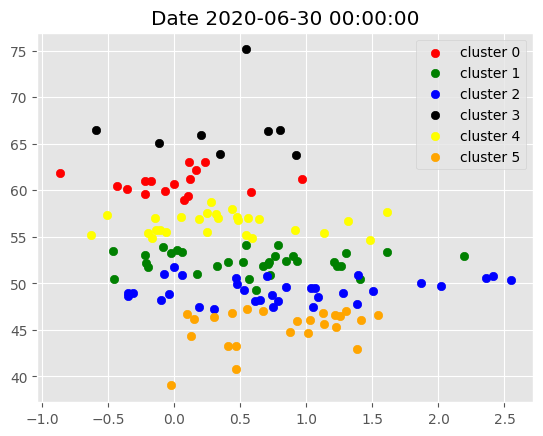

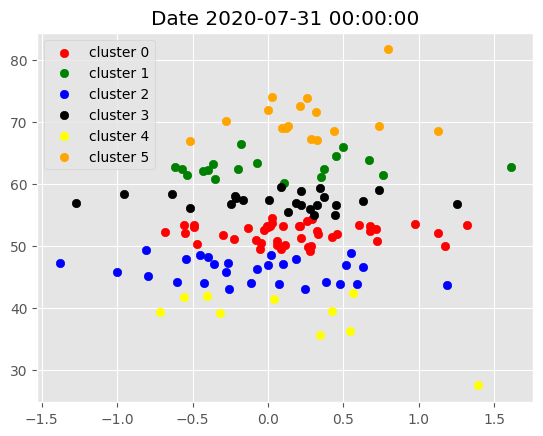

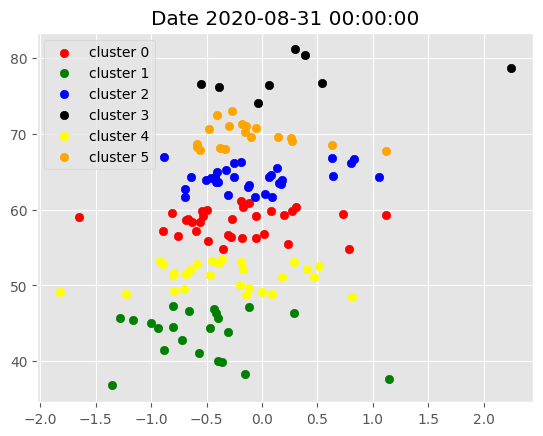

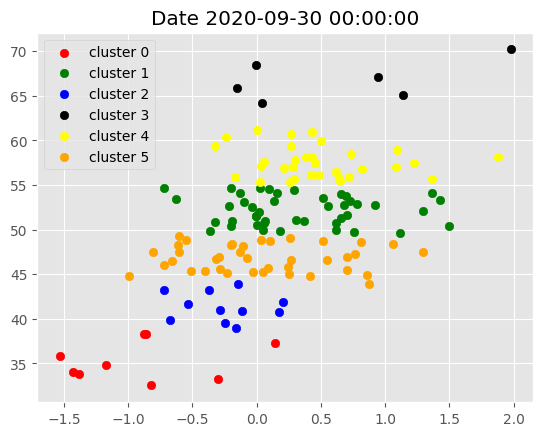

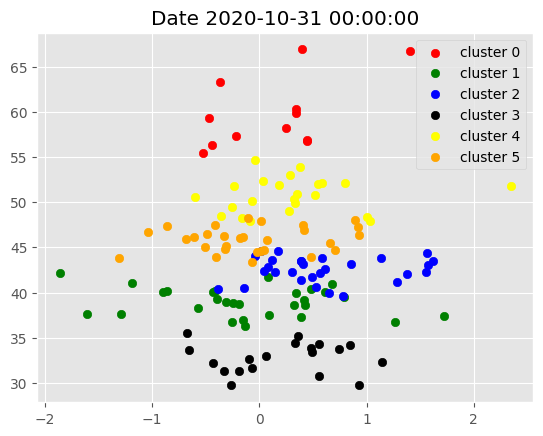

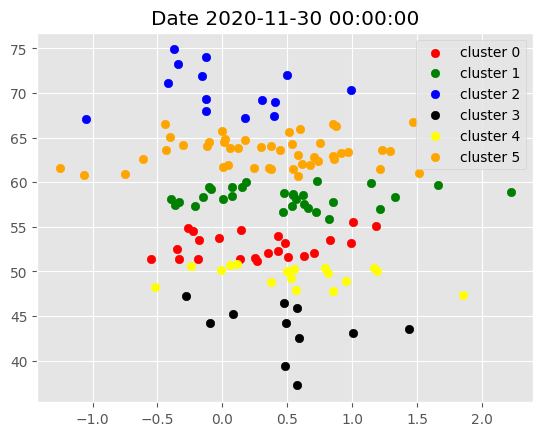

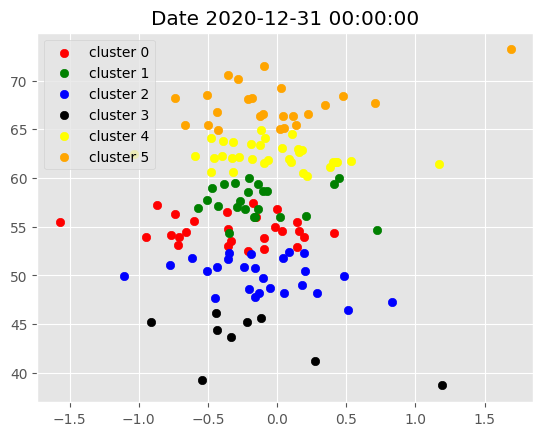

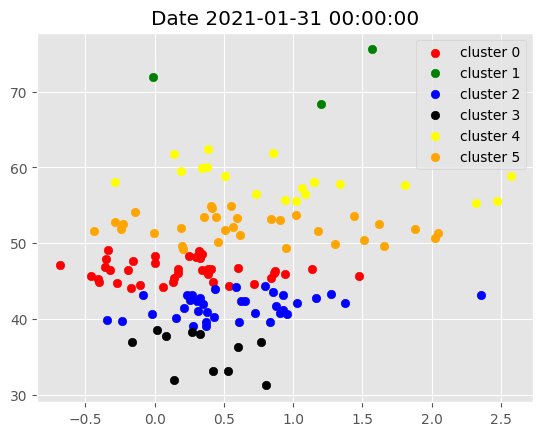

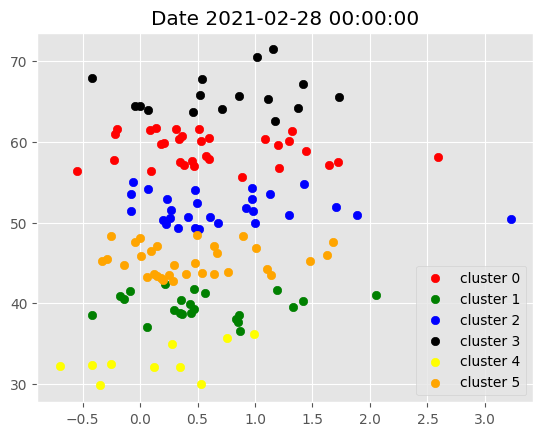

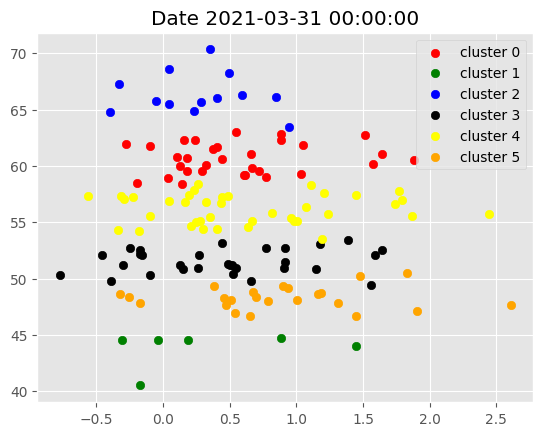

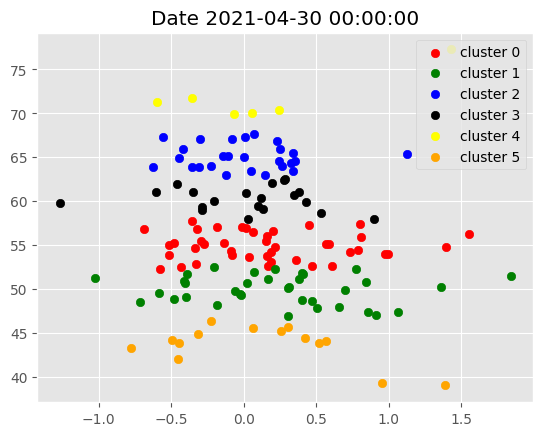

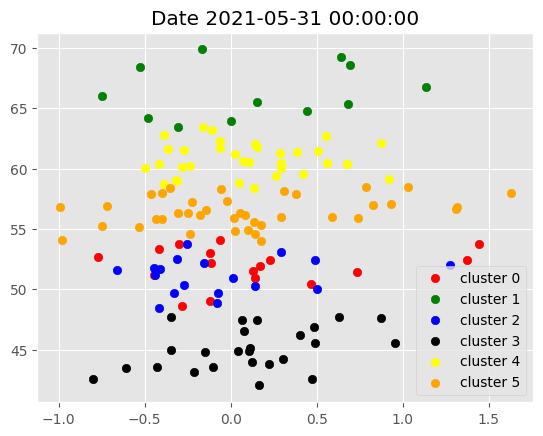

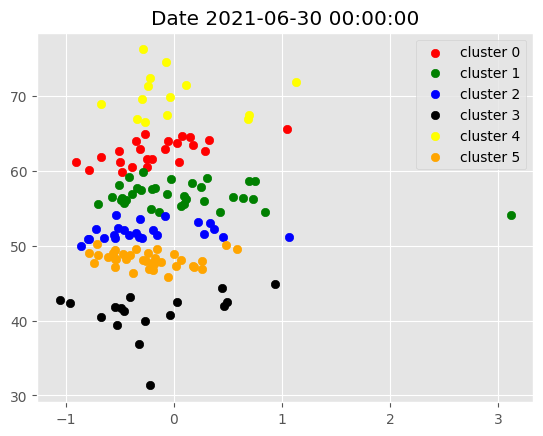

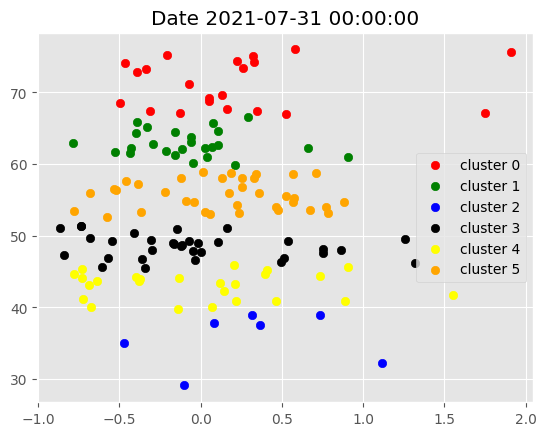

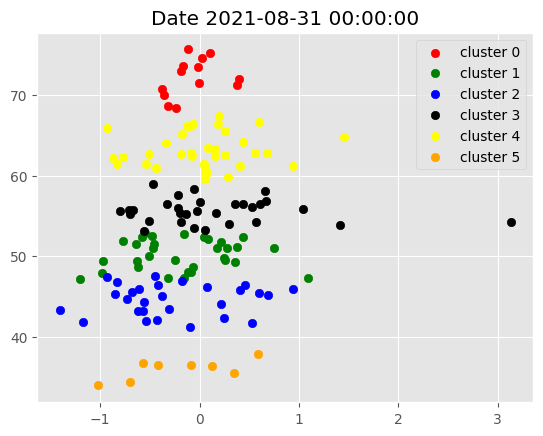

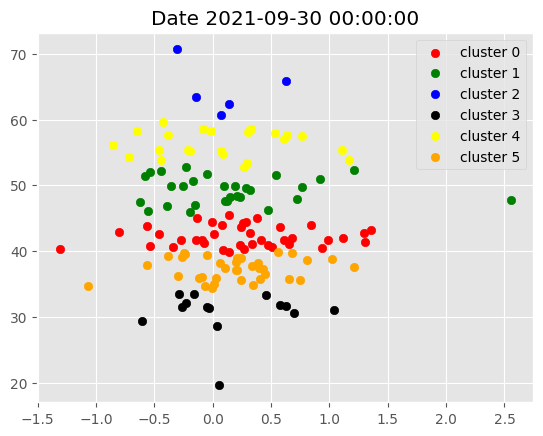

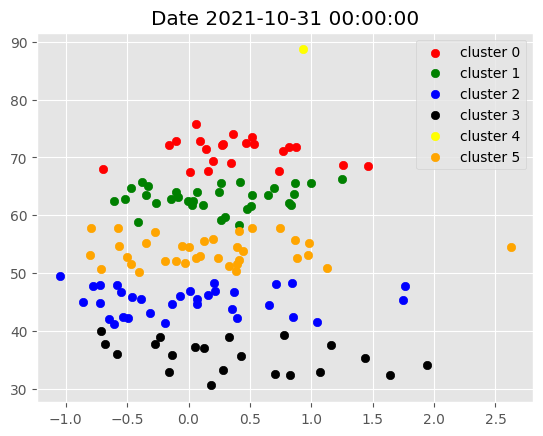

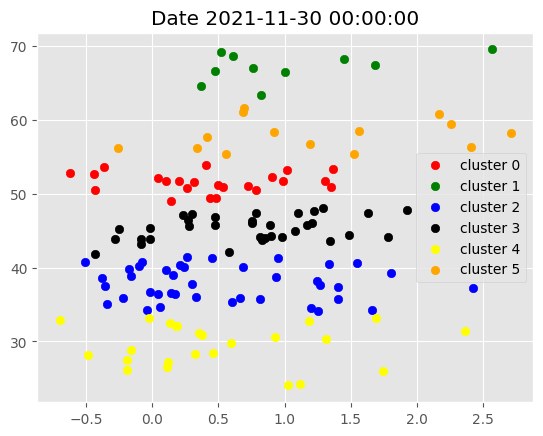

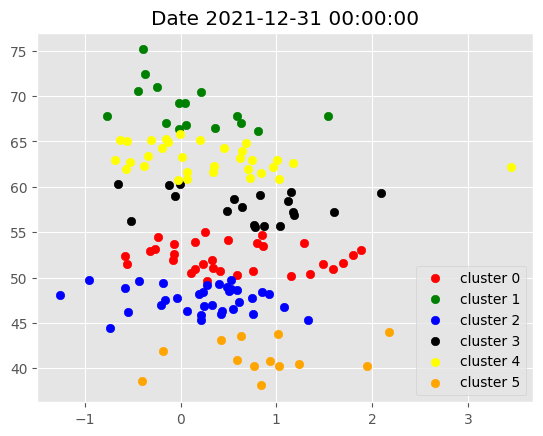

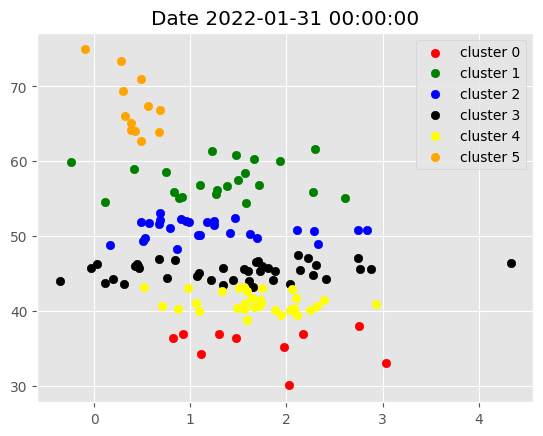

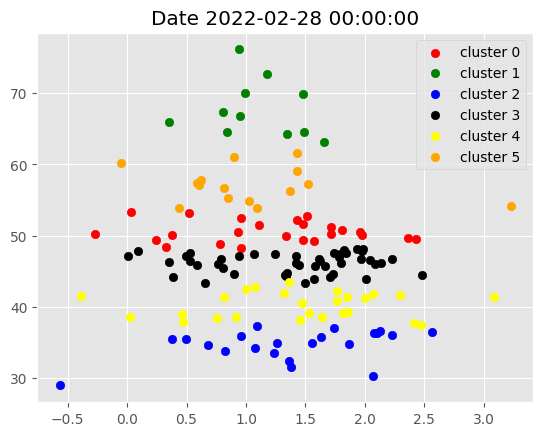

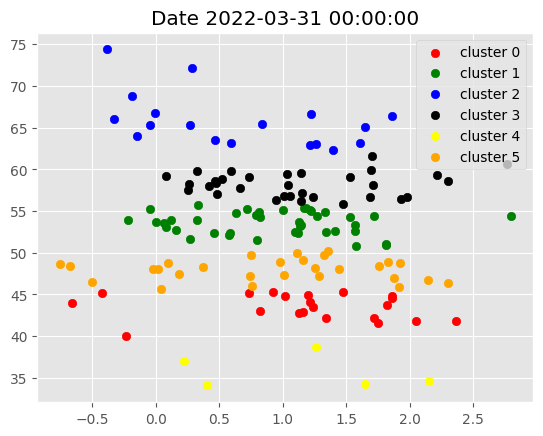

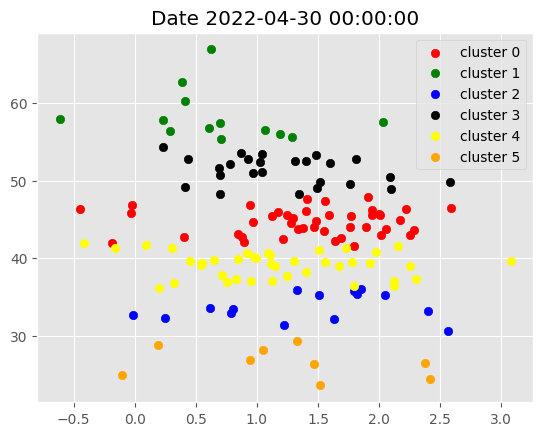

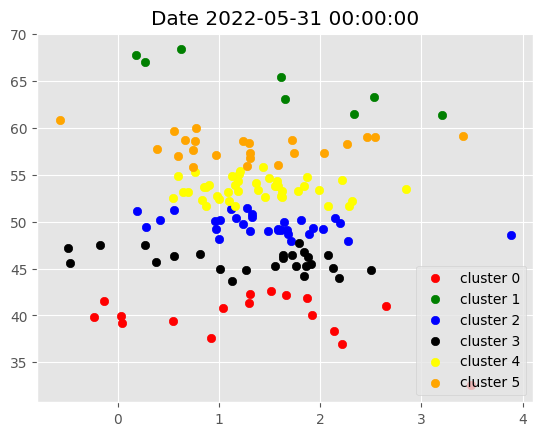

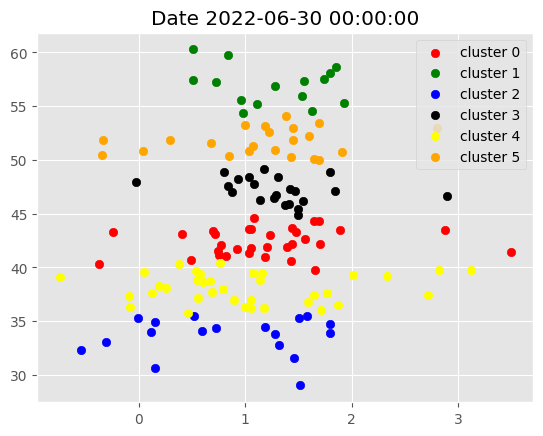

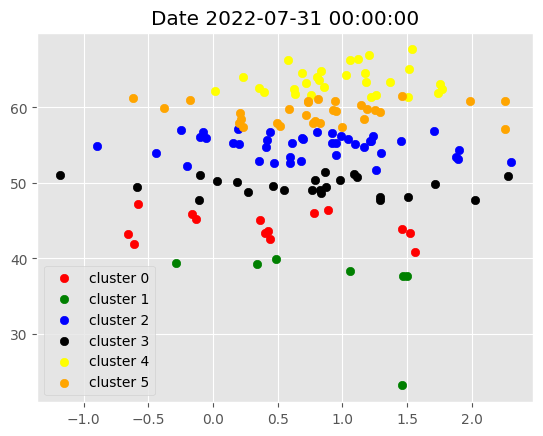

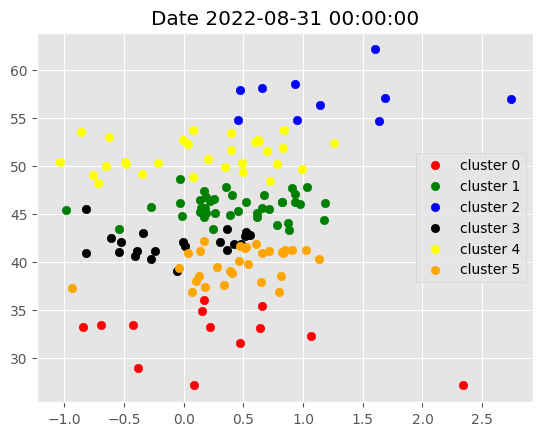

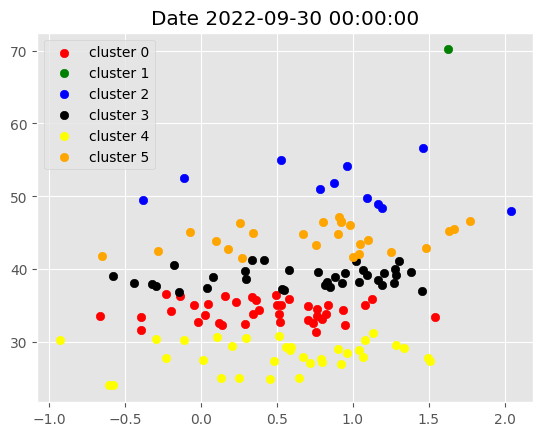

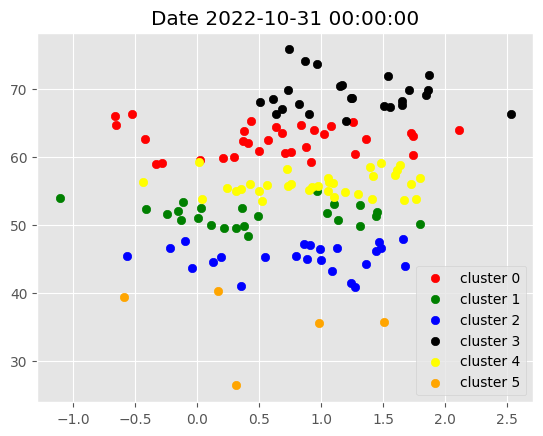

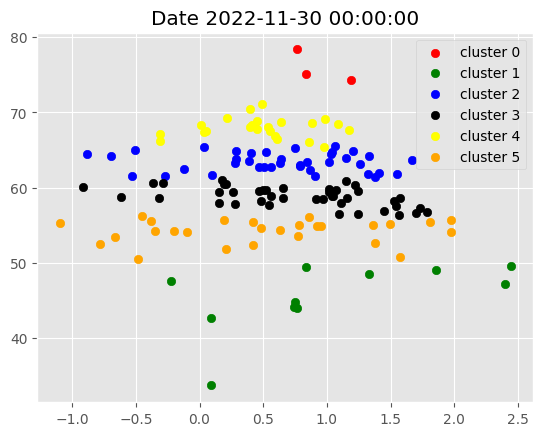

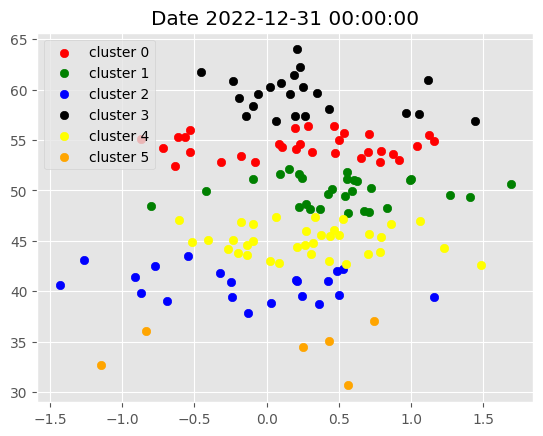

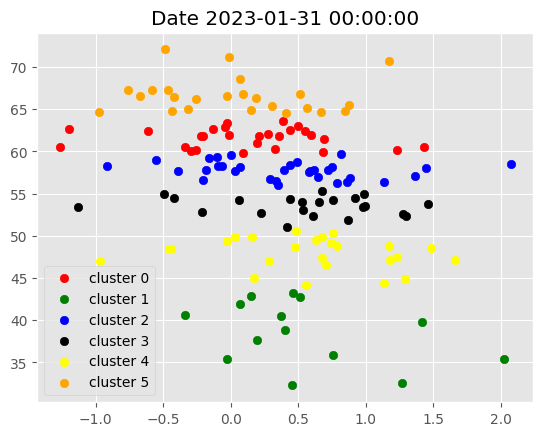

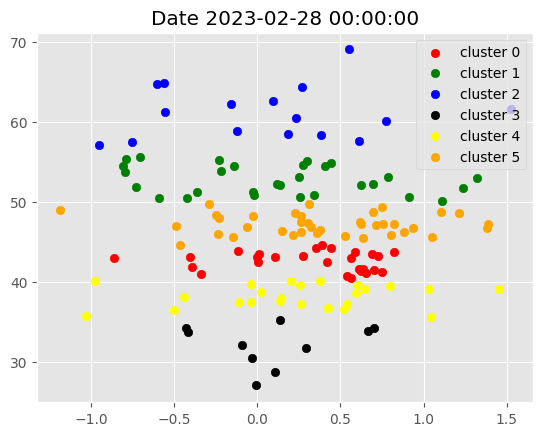

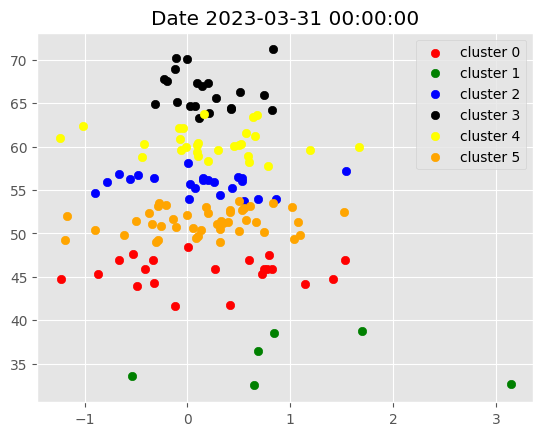

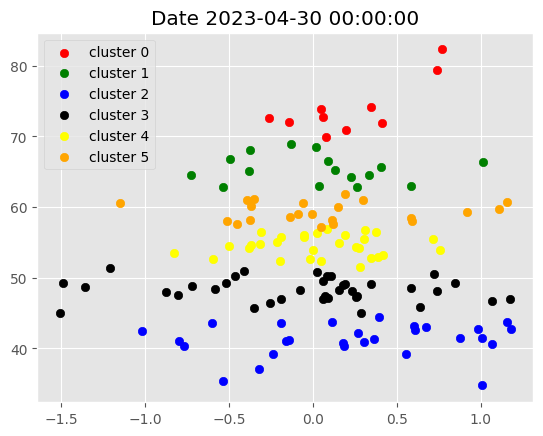

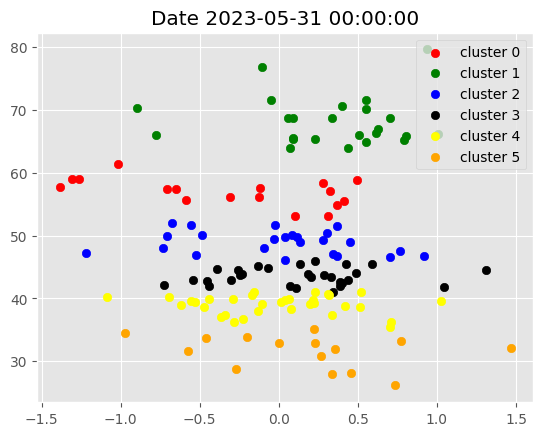

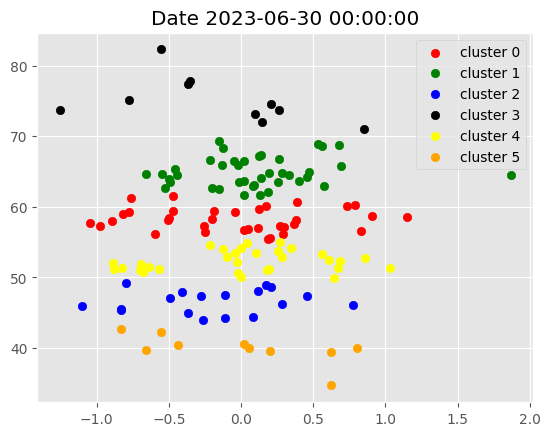

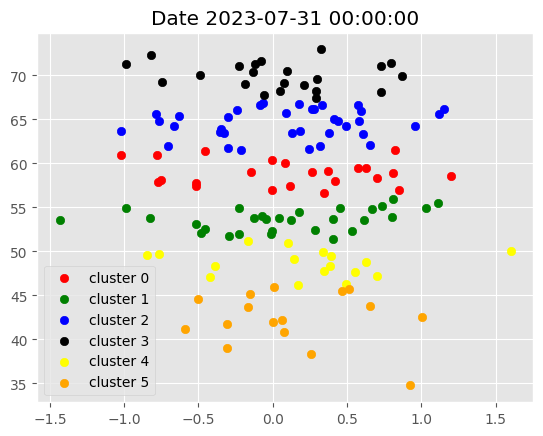

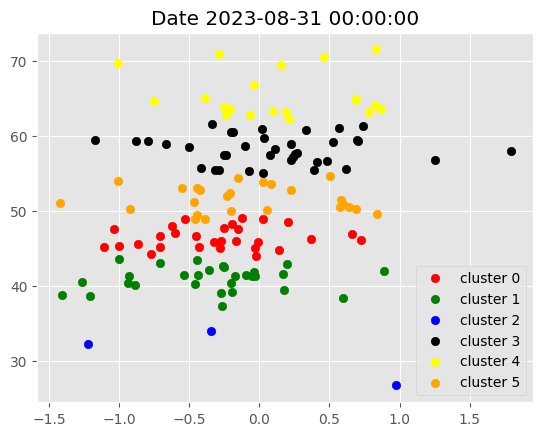

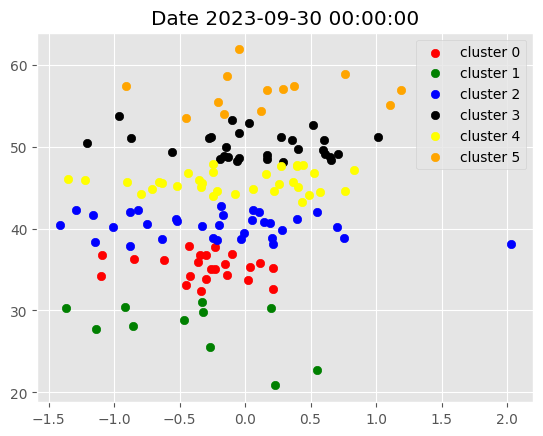

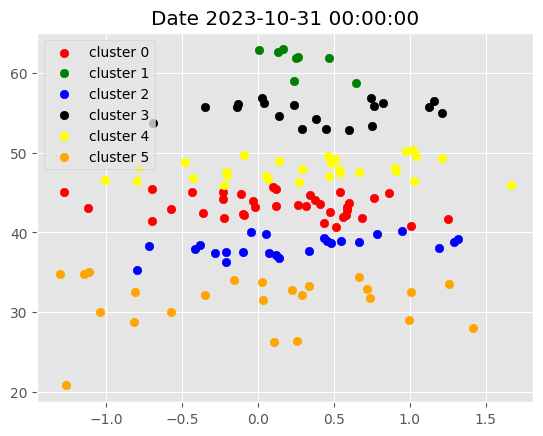

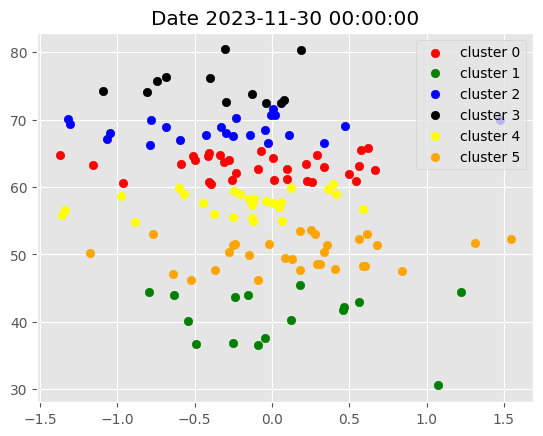

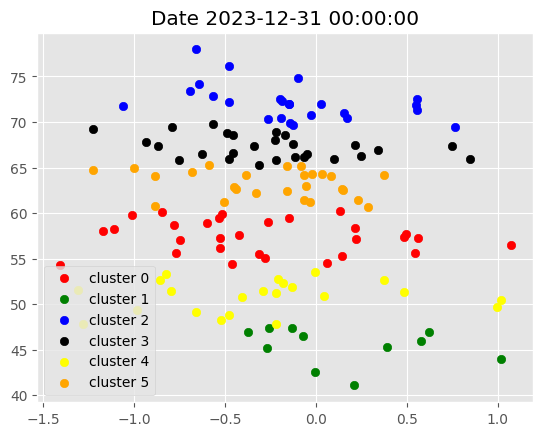

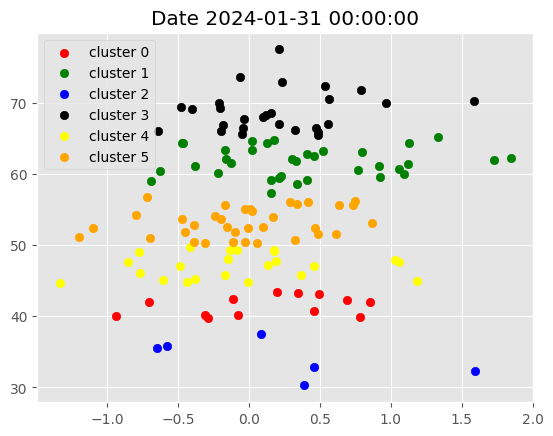

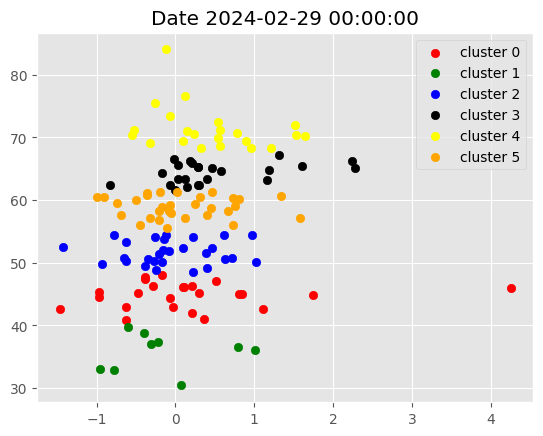

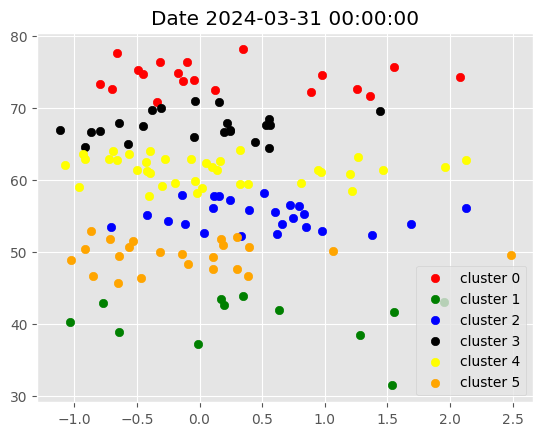

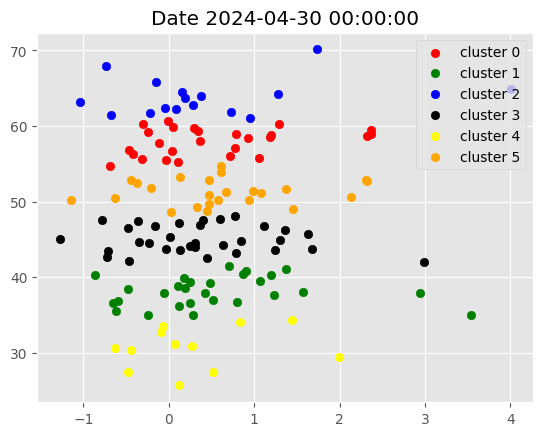

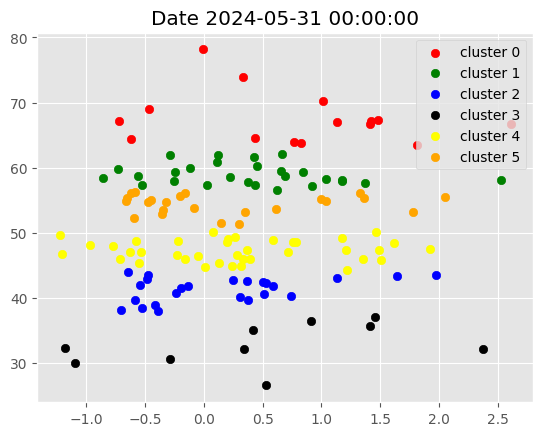

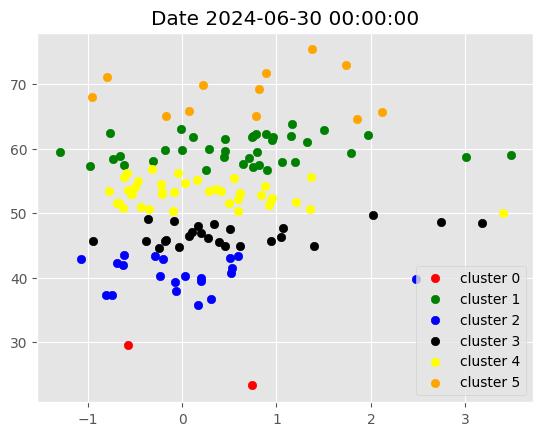

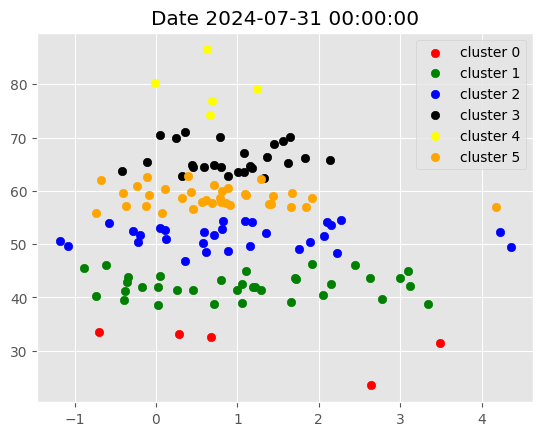

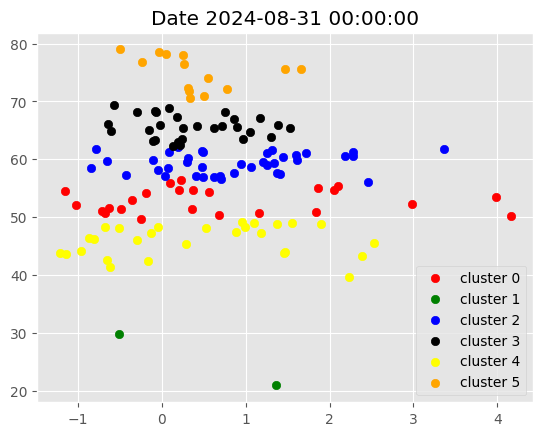

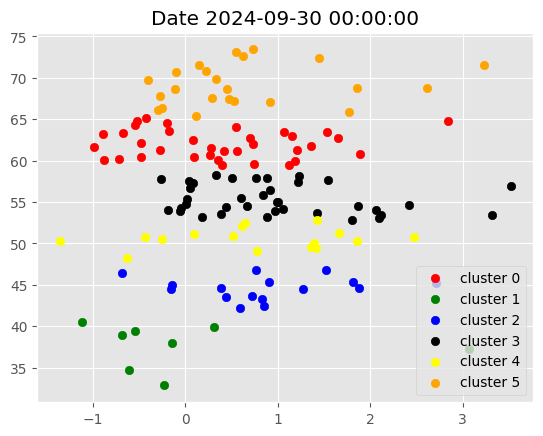

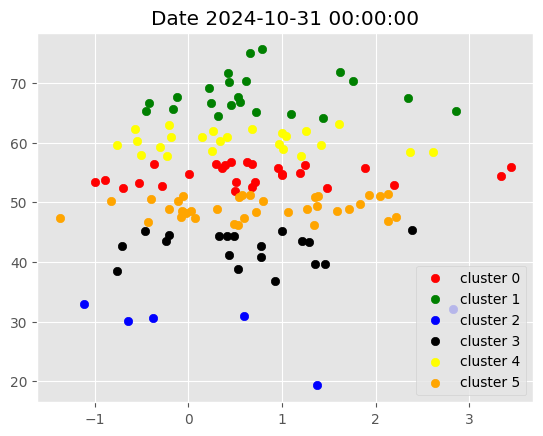

In [37]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    g = data.xs(i, level=0)
    plt.title(f'Date {i}')
    
    plot_clusters(g)

### Apply pre-defined centroids.

In [38]:
target_rsi_values = CLUSTER_TARGET_RSI_VALUE

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 20.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 40.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 50.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 60.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

## 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.


In [39]:
filtered_df = data[data["cluster"] == (len(CLUSTER_TARGET_RSI_VALUE)-1)].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2018-11-01': ['AAPL',
  'ABT',
  'ADP',
  'BKNG',
  'CHTR',
  'CMG',
  'COST',
  'CSCO',
  'DAL',
  'DIS',
  'DLTR',
  'ELV',
  'EXPE',
  'GS',
  'INTC',
  'ISRG',
  'JPM',
  'LLY',
  'MDLZ',
  'MGM',
  'MS',
  'NEE',
  'ORCL',
  'PEP',
  'PFE',
  'PYPL',
  'TJX',
  'TMO',
  'TMUS',
  'UAL',
  'ULTA',
  'UNH',
  'USB',
  'WFC'],
 '2018-12-01': ['AMD',
  'AMZN',
  'BA',
  'BAC',
  'BMY',
  'CMG',
  'DD',
  'DG',
  'DIS',
  'EBAY',
  'EXPE',
  'F',
  'FCX',
  'FDX',
  'GOOG',
  'GOOGL',
  'HD',
  'HON',
  'IBM',
  'KR',
  'LUV',
  'MA',
  'MGM',
  'MS',
  'NKE',
  'NXPI',
  'ORCL',
  'ORLY',
  'PM',
  'PYPL',
  'T',
  'TMUS',
  'V',
  'WMT',
  'WYNN',
  'XOM'],
 '2019-01-01': ['ADBE',
  'ADI',
  'ADSK',
  'AMAT',
  'AMT',
  'BA',
  'BLK',
  'BMY',
  'BRK-B',
  'CAT',
  'DD',
  'DIS',
  'GOOG',
  'GOOGL',
  'HD',
  'INTC',
  'ISRG',
  'KO',
  'LOW',
  'MA',
  'MCD',
  'MDT',
  'MMM',
  'MSFT',
  'NEE',
  'NFLX',
  'PYPL',
  'QCOM',
  'SHW',
  'TSLA',
  'TXN',
  'V',
  'VRTX',
  'VZ',
  

### Define portfolio optimization function

* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [40]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()


* Download Fresh Daily Prices Data only for short listed stocks.

In [41]:
stocks = data.index.get_level_values('ticker').unique().tolist()

if USE_BACKUP is True:
    new_df =  pd.read_pickle("data3.pkl")
else:
    new_df = yf.download(tickers=stocks,
                         start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                         end=data.index.get_level_values('date').unique()[-1])
if BACKUP_DATA is True:
    new_df.to_pickle("data3.pkl")

new_df.index = new_df.index.tz_localize(None)

copy4 = new_df.copy()

new_df

Price        Adj Close                                                  \
Ticker            AAPL        ABBV         ABT         ACN        ADBE   
Date                                                                     
2017-10-31   39.667992   66.876816   48.237457  128.834732  175.160004   
2017-11-01   39.163460   68.499626   48.032894  129.377686  176.250000   
2017-11-02   39.449749   67.447395   48.361988  129.803055  180.940002   
2017-11-03   40.479939   68.403305   49.340443  130.355103  182.300003   
2017-11-06   40.890598   68.884964   48.931274  130.255524  180.800003   
...                ...         ...         ...         ...         ...   
2024-09-27  227.789993  194.789993  112.430000  349.700012  515.479980   
2024-09-30  233.000000  197.479996  114.010002  353.480011  517.780029   
2024-10-01  226.210007  196.960007  113.559998  351.980011  502.799988   
2024-10-02  226.779999  196.820007  113.639999  356.290009  505.809998   
2024-10-03  225.669998  195.449997  112.230003  361.239990  503.799988   

Price                                                                  ...  \
Ticker             ADI         ADP        ADSK        AIG        ALGN  ...   
Date                                                                   ...   
2017-10-31   79.939713  100.318542  124.959999  53.633953  238.979996  ...   
2017-11-01   79.668304   99.576454  124.779999  53.675472  234.949997  ...   
2017-11-02   79.493187   98.661781  124.720001  53.941113  233.470001  ...   
2017-11-03   80.386253   96.849754  124.849998  51.467350  241.350006  ...   
2017-11-06   80.797775   96.064522  123.820000  51.874119  244.500000  ...   
...                ...         ...         ...        ...         ...  ...   
2024-09-27  232.050003  272.880005  271.899994  73.339996  254.809998  ...   
2024-09-30  230.169998  276.730011  275.480011  73.230003  254.320007  ...   
2024-10-01  223.669998  280.079987  267.470001  72.720001  245.350006  ...   
2024-10-02  227.729996  283.549988  270.170013  72.449997  238.059998  ...   
2024-10-03  226.559998  284.619995  268.589996  72.339996  236.970001  ...   

Price        Volume                                                           \
Ticker            V      VLO     VRTX        VZ       WBA      WDC       WFC   
Date                                                                           
2017-10-31  8002500  3231000  2457100  15910000  12224700  5661000  14619200   
2017-11-01  6167300  4097800  2412600  11046600   9702600  3780000  11678300   
2017-11-02  5506600  4972900  2050000  13126900   8042600  2605600  15630000   
2017-11-03  3757600  3390500  1884900   8038200  14066400  2942700  10049200   
2017-11-06  4094700  3326200  1608300  36443300   5949600  3084300  10414900   
...             ...      ...      ...       ...       ...      ...       ...   
2024-09-27  6509600  2935800   710700  15659300  27385300  4091800  13530400   
2024-09-30  5969900  2623400   808000  13509700  20239900  5327000  16284200   
2024-10-01  5781600  3227000  1128900  17536400  19936900  3490100  11069400   
2024-10-02  4741600  3024700   897200  12040800  15702900  3828800   9007200   
2024-10-03  3035200  5224000   992700  12257600  13928100  3964300   8134100   

Price                                     
Ticker           WMT      WYNN       XOM  
Date                                      
2017-10-31  18020700   3938100   9754200  
2017-11-01  18528300   3463900   9430000  
2017-11-02  15549300   1357300   7775500  
2017-11-03  19536300   1213700   6903500  
2017-11-06  15772200   1772800   9276700  
...              ...       ...       ...  
2024-09-27  11899100  11253100  15964000  
2024-09-30  18997000   6224800  13247600  
2024-10-01  16054200   4771200  23235900  
2024-10-02  16618300   4512300  17129700  
2024-10-03  11591400   3880000  16514200  

[1742 rows x 924 columns]

* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

In [42]:
new_df = copy4.copy()

returns_dataframe = np.log(new_df["Adj Close"]).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    try:
        end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime(
            "%Y-%m-%d"
        )
        cols = fixed_dates[start_date]
        optimization_start_date = (
            pd.to_datetime(start_date) - pd.DateOffset(months=12)
        ).strftime("%Y-%m-%d")
        optimization_end_date = (
            pd.to_datetime(start_date) - pd.DateOffset(days=1)
        ).strftime("%Y-%m-%d")
        optimization_df = new_df[optimization_start_date:optimization_end_date][
            "Adj Close"
        ][cols]
        success = False
        try:
            weights = optimize_weights(
                prices=optimization_df,
                lower_bound=round(1 / (len(optimization_df.columns) * 2), 3),
            )
            success = True
        except:
            print(
                f"Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights"
            )
        if success == False:
            weights = {
                ticker: 1 / len(optimization_df.columns)
                for ticker in optimization_df.columns
            }

        temp_df = returns_dataframe[start_date:end_date]
        temp_df = temp_df.stack()
        temp_df.index.names = ["Date", "Ticker"]
        temp_df = temp_df.to_frame("return").reset_index()

        weights_df = pd.DataFrame(
            list(weights.values()), index=weights.keys(), columns=["weight"]
        ).reset_index()
        weights_df.rename(columns={"index": "Ticker"}, inplace=True)

        temp_df = temp_df.merge(weights_df, on="Ticker")
        temp_df = temp_df.set_index(["Date", "Ticker"])
        temp_df["weighted_return"] = temp_df["return"] * temp_df["weight"]
        temp_df = (
            temp_df.groupby(level=0)["weighted_return"]
            .sum()
            .to_frame("Strategy Return")
        )
        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2019-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-07-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-11-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-01-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-07-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-11-01, Continuing with Equal-Weights

,Strategy Return
Date,
2018-11-01,0.006890
2018-11-02,-0.002809
2018-11-05,0.007559
2018-11-06,0.001398
2018-11-07,0.019404
...,...
2024-09-27,-0.000275
2024-09-30,0.004626
2024-10-01,0.004439


## 8. Performance and Risk Assessment of ML Strategies

Benchmark strategies have been introduced for comparison
- S&P Buy and Hold

In [43]:

if USE_BACKUP is True:
    spy =  pd.read_pickle("data4.pkl")
else:
    spy = yf.download(tickers='SPY',
                    start='2015-01-01',
                    end=dt.date.today())
    
if BACKUP_DATA is True:
    spy.to_pickle("data4.pkl")

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

,Strategy Return,SPY Buy&Hold
Date,,
2018-11-01,0.006890,0.010586
2018-11-02,-0.002809,-0.005941
2018-11-05,0.007559,0.005502
2018-11-06,0.001398,0.006308
2018-11-07,0.019404,0.021183
...,...,...
2024-09-27,-0.000275,-0.001451
2024-09-30,0.004626,0.003999
2024-10-01,0.004439,-0.008999


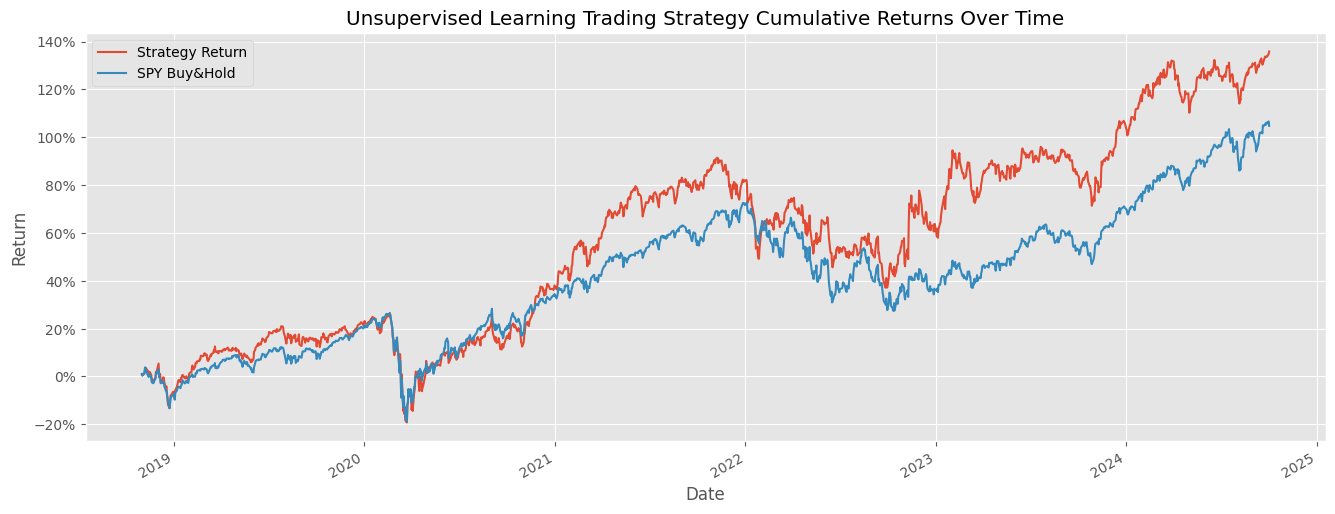

In [44]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2024-10-01'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Cumulative Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()


Calculate the variance from 2019-11-1 to 2024-10-1
- Use past 252 records (approximately 1 year)

In [45]:
vol = portfolio_df.rolling(window=252).var().dropna()**0.5
vol_annnualized = vol * 252**0.5

vol_annnualized.mean()

Strategy Return    0.234378
SPY Buy&Hold       0.198055
dtype: float64

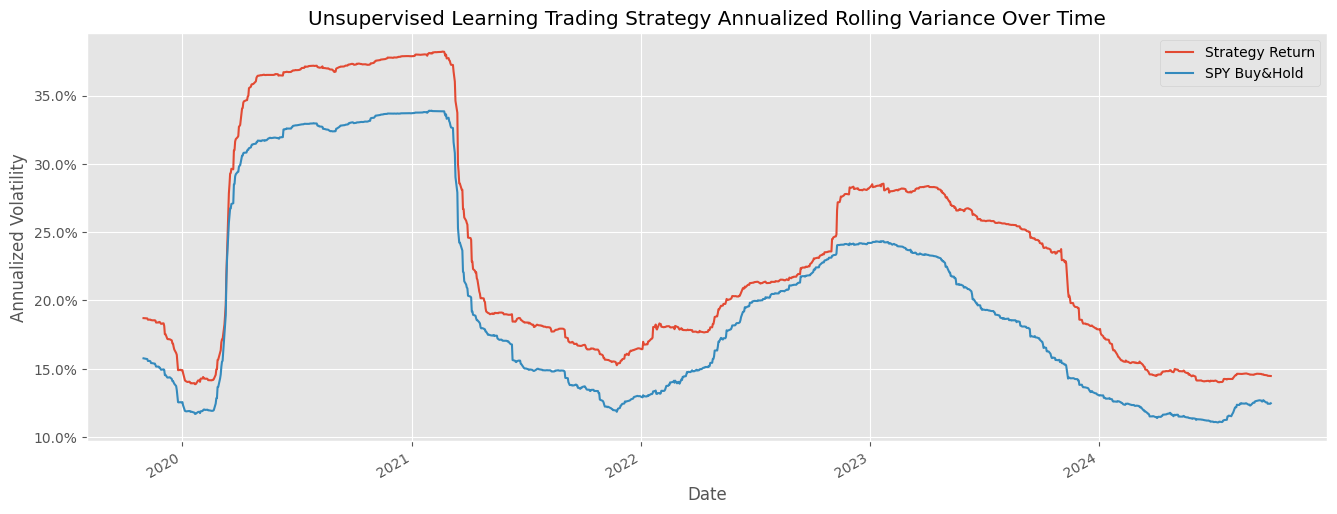

In [46]:
vol_annnualized[:'2024-10-01'].plot(figsize=(16,6))
plt.title('Unsupervised Learning Trading Strategy Annualized Rolling Variance Over Time')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Annualized Volatility')
plt.show()

Calculate beta against market portfolio to assess the market risk

In [47]:
X = portfolio_df['SPY Buy&Hold']
X = sm.add_constant(X)
y = portfolio_df['Strategy Return']
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        Strategy Return   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     4265.
Date:                Fri, 29 Nov 2024   Prob (F-statistic):               0.00
Time:                        16:41:52   Log-Likelihood:                 5159.4
No. Observations:                1489   AIC:                        -1.031e+04
Df Residuals:                    1487   BIC:                        -1.030e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0001      0.000      0.622   

Calculate the Sharp ratio to assess the risk-adjusted return
- Calculation up to 2024-10-1
- Use 1-year US treasury bill to approximate the risk-free rate

In [48]:
def cum_return_year(df, year):
    df_year = df.loc[df.index.year == year]
    return (1 + df_year).prod() - 1

def vol_year(df, year):
    return (df.loc[df.index.year == year].var() * 252) ** 0.5

In [49]:
# Retrieve risk-free rate
symbol = 'DGS1'
rf = web.DataReader(symbol, 'fred', '2019-1-1', '2024-10-1').dropna()
rf = rf.resample('Y').mean()/100

# Calculate annual portfolio return
tmp = portfolio_df['2019-1-1':]
date_range = pd.date_range(start='2019-12-31', end='2024-12-31', freq='A')
rp = pd.DataFrame(index=date_range, columns=['ML Strategy', 'SPY Buy&Hold'])

for i in range(2019,2025):
    ret = cum_return_year(tmp, i)
    rp.loc[str(i)+'-12-31', 'ML Strategy'] = ret['Strategy Return']
    rp.loc[str(i)+'-12-31', 'SPY Buy&Hold'] = ret['SPY Buy&Hold']

# Calculate risk premium of the strategies
rpf = rp.sub(rf[symbol], axis=0)

# Calculate the annual volatility for each year
sigma_p = pd.DataFrame(index=date_range, columns=['ML Strategy Vol'])
for i in range(2019,2025):
    sigma = vol_year(tmp['Strategy Return'], i)
    sigma_p.loc[str(i)+'-12-31'] = sigma

# Calculate Sharp Ratio
sharp = rpf.div(sigma_p['ML Strategy Vol'], axis=0)
sharp

,ML Strategy,SPY Buy&Hold
2019-12-31,1.8857,1.889698
2020-12-31,0.341557,0.300285
2021-12-31,1.917463,1.670882
2022-12-31,-0.450375,-0.826455
2023-12-31,1.158716,1.120342
2024-12-31,0.722902,1.153666


### There are a few important distinctions to make:

1. **SPY Buy & Hold** is not exactly "ground truth" in the way you would typically use that term in machine learning. Instead, SPY Buy & Hold is a **benchmark** representing the performance of the S&P 500 index, a proxy for the overall market performance. It serves as a baseline to compare the performance of other strategies. 

2. **Strategy Return** is not necessarily a **prediction** in the sense of predicting future stock prices or returns. It's the result of applying your **trading strategy** to historical data. If you're using a machine learning model, the strategy is likely based on learned patterns, but it isn't directly a prediction of future prices. It's more of a **backtest** to see how well the strategy would have performed using historical data.


### Comparing Strategy Return to SPY Buy & Hold:

1. **If Strategy Return matches SPY Buy & Hold**: 
   - This means your strategy performed similarly to simply holding the SPY ETF during the backtest period. While this is not a *bad* result, it indicates that your strategy **did not add any value over a basic market investment**. You could have achieved the same returns with less effort and fewer risks just by buying and holding SPY.
   - In this case, your model or strategy is likely not extracting useful features or insights to outperform the market. It's **not enough** to say the model is good just because it's similar to SPY.

2. **If Strategy Return outperforms SPY Buy & Hold**:
   - This is a better result. If your strategy consistently generates **higher cumulative returns** than SPY Buy & Hold, it suggests that your model has identified some useful patterns or features that allow it to outperform the market. This would indicate that your trading strategy adds value and can beat the market.
   - In this case, your model might be considered good, but you'll also need to assess its **risk-adjusted performance** (e.g., using Sharpe Ratio, Max Drawdown).

3. **If Strategy Return underperforms SPY Buy & Hold**:
   - This indicates that your strategy is worse than simply buying and holding the market. It might mean that your model is either overfitting the data, capturing noise, or using features that don’t provide useful predictive information.
   - In this case, the strategy is not performing well, and the model would need improvement or further testing.

### Key Metrics to Consider Beyond Returns:

- **Sharpe Ratio**: This measures the risk-adjusted return. A higher Sharpe Ratio means the strategy generates higher returns for each unit of risk taken. If your strategy has a higher Sharpe Ratio than SPY, it might be considered better, even if the raw returns are similar.
  
- **Max Drawdown**: This is the largest peak-to-trough decline during the investment period. If your strategy has a much lower drawdown than SPY, it might be preferable, even if the returns are similar.

- **Volatility**: Lower volatility with similar returns suggests a smoother performance with fewer fluctuations, which may indicate a more stable strategy.

### What Constitutes a "Good" Feature Set:

- **Feature Quality**: If your strategy is consistently beating the market (outperforming SPY) with higher risk-adjusted returns, it suggests that the features used by your model are extracting useful information from the data.
  
- **Feature Redundancy**: If your strategy return closely mimics SPY, it might indicate that your features are **too similar** to what is already captured by the market (e.g., they might be correlated with market returns), so your model isn't adding value.

### Conclusion:

- A strategy that **outperforms SPY Buy & Hold** is generally considered better, but you need to also look at risk metrics (like Sharpe Ratio or Drawdown) to get a full picture of performance.
- If your **Strategy Return is the same as SPY Buy & Hold**, it suggests your model isn't adding value, and you might need to refine your features or strategy.
- The goal in trading is usually to **outperform the market**, not just match it. So, consistent outperformance with controlled risk would be a sign of a strong model or strategy.


### Predict Stock Price with RandomForestRegressor

In [50]:
data = model_train_data

data = data.sort_index(level=['ticker', 'date'])

data['future_return_1m'] = data.groupby('ticker')['return_1m'].shift(-1)

data = data.dropna(subset=['future_return_1m'])

# Reset index if necessary
data = data.reset_index()

In [51]:
# Twitter sentiment data is not enought to be used as a feature as only got 1.5 years of data

# If can get more (at least 5 years) then can use it as a feature

# But remind that the length of the original data is 10 years

features = [
    "atr",
    "bb_high",
    "bb_low",
    "bb_mid",
    "garman_klass_vol",
    "macd",
    "rsi",
    "return_1m",
    "return_2m",
    "return_3m",
    "return_6m",
    "return_9m",
    "return_12m",
    "Mkt-RF",
    "SMB",
    "HML",
    "RMW",
    "CMA",
    "cluster",  # Include cluster as a feature
    # "engagement_ratio", # New sentiment feature
    # "twitterLikes",     # New sentiment feature
    # "twitterComments",  # New sentiment feature
]

X = data[features]
y = data['future_return_1m']

# X = full_df[features]
# y = full_df['future_return']

X = X.dropna()
y = y[X.index]

# X = X.dropna()
# y = y.loc[X.index]

# One-hot encode 'cluster' if necessary
X = pd.get_dummies(X, columns=['cluster'], prefix='cluster')

data

,date,ticker,atr,bb_high,bb_low,bb_mid,garman_klass_vol,macd,rsi,return_1m,...,return_6m,return_9m,return_12m,Mkt-RF,SMB,HML,RMW,CMA,cluster,future_return_1m
0,2018-10-31,AAPL,-0.535302,4.014081,3.937351,3.975716,-0.000440,-0.453664,50.232911,-0.030478,...,0.049216,0.031518,0.023037,1.308384,-0.284239,-0.628617,0.376332,0.559993,5,-0.157549
1,2018-11-30,AAPL,-0.604458,3.959571,3.707130,3.833351,-0.000970,-1.324799,36.859892,-0.157549,...,-0.006378,0.001491,0.004453,1.308384,-0.284239,-0.628617,0.376332,0.559993,4,-0.116698
2,2018-12-31,AAPL,-0.626877,3.810297,3.586115,3.698206,-0.000792,-1.240985,37.072893,-0.116698,...,-0.025181,-0.005637,-0.004607,1.308384,-0.284239,-0.628617,0.376332,0.559993,3,0.055154
3,2019-01-31,AAPL,-0.789154,3.698256,3.565677,3.631967,-0.000354,-0.361665,53.482555,0.055154,...,-0.020933,0.001996,0.000748,1.308384,-0.284239,-0.628617,0.376332,0.559993,4,0.044777
4,2019-02-28,AAPL,-1.104735,3.767871,3.712552,3.740212,-0.000797,0.041393,57.086875,0.044777,...,-0.042890,-0.007195,-0.001098,1.308384,-0.284239,-0.628617,0.376332,0.559993,5,0.097026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,2024-05-31,XOM,0.612793,4.787623,4.725027,4.756325,0.000316,-0.516598,53.608624,-0.000487,...,0.025235,0.008883,0.014459,0.787192,-0.105150,0.679429,0.879070,0.322012,5,-0.018250
10123,2024-06-30,XOM,0.409523,4.764615,4.685024,4.724820,0.000049,-0.346034,53.431099,-0.018250,...,0.026742,0.000589,0.008824,0.794063,-0.088807,0.447962,0.752115,0.528044,4,0.030142
10124,2024-07-31,XOM,0.559681,4.786663,4.708335,4.747499,-0.000059,0.672219,57.851749,0.030142,...,0.027048,0.015688,0.011331,0.742123,0.056813,0.401031,0.849255,0.534282,5,0.002526
10125,2024-08-31,XOM,0.557727,4.798463,4.737298,4.767880,0.000072,0.351177,54.346519,0.002526,...,0.023080,0.018314,0.007813,0.631060,-0.092122,0.297566,0.608340,1.041702,0,-0.006105


In [52]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [53]:
data['date'] = pd.to_datetime(data['date'])

# Set the cutoff date for prevent data leakage on training dataset
cutoff_date = pd.to_datetime('2023-01-01')

# Create boolean masks
train_mask = data['date'] <= cutoff_date
test_mask = data['date'] > cutoff_date

# train_mask = full_df['date'] <= cutoff_date
# test_mask = full_df['date'] > cutoff_date

# Split the data
X_train = X_scaled[train_mask]
y_train = y[train_mask]
X_test = X_scaled[test_mask]
y_test = y[test_mask]


In [54]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

# import joblib
# # Save the model to a file
# joblib.dump(model, 'random_forest_model.joblib')
# model = joblib.load('random_forest_model.joblib')


RandomForestRegressor(random_state=42)

In [55]:
y_pred = model.predict(X_test)

In [56]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Test MSE: {mse}')
print(f'Test R-squared: {r2}')

# from sklearn.model_selection import TimeSeriesSplit, cross_val_score

# tscv = TimeSeriesSplit(n_splits=5)
# scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error')

# print("Cross-Validation MSE Scores:", -scores)
# print("Mean CV MSE:", -scores.mean())


Test MSE: 0.007394814176054579
Test R-squared: -0.08104694245556199


In [57]:
results_df = data[test_mask].copy()
results_df['predicted_return'] = y_pred

results_df['date'] = pd.to_datetime(results_df['date'])

results_df = results_df.sort_values(by='date')

In [58]:
daily_returns = results_df.groupby('date').agg({
    'future_return_1m': 'mean',
    'predicted_return': 'mean'
}).reset_index()

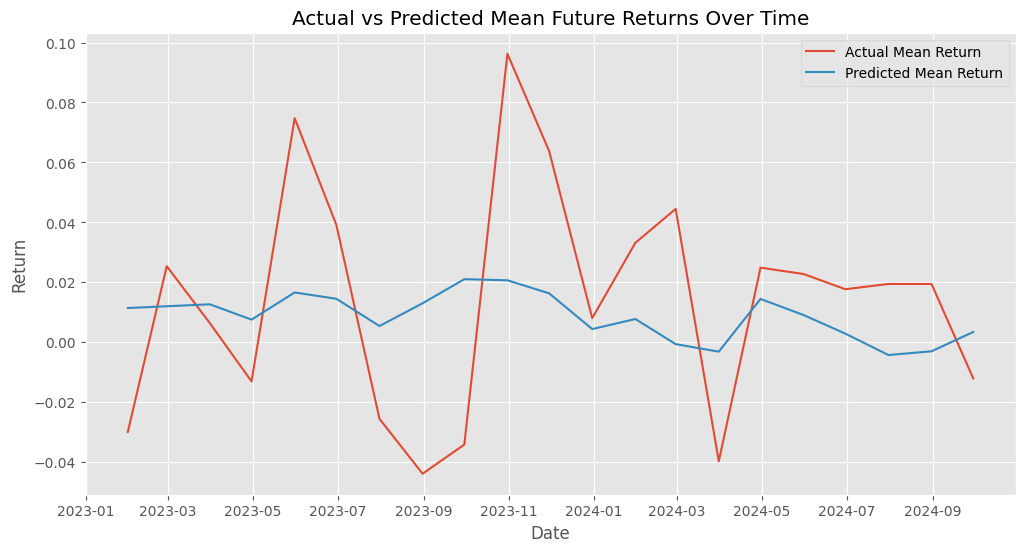

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(daily_returns['date'], daily_returns['future_return_1m'], label='Actual Mean Return')
plt.plot(daily_returns['date'], daily_returns['predicted_return'], label='Predicted Mean Return')
plt.title('Actual vs Predicted Mean Future Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.show()


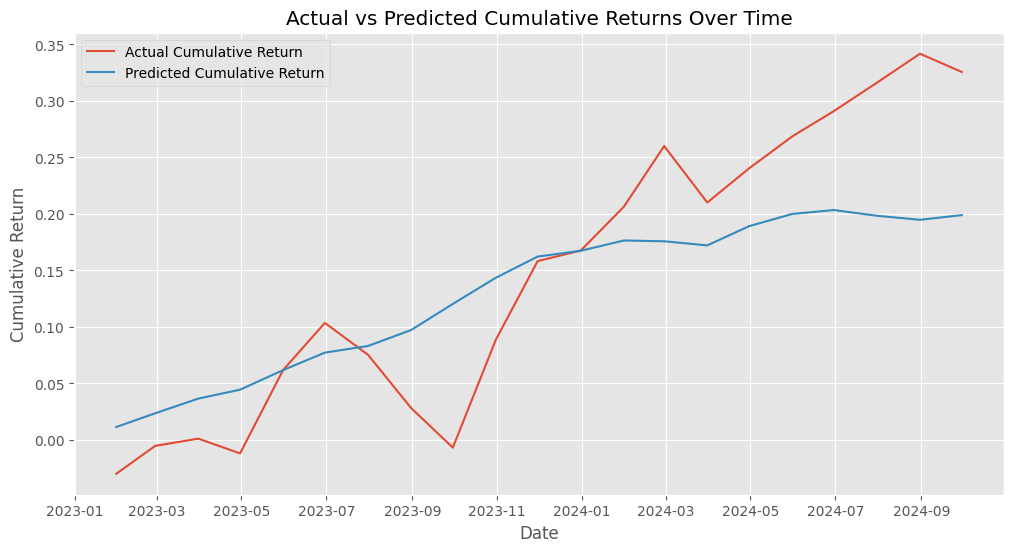

In [60]:
# Calculate cumulative returns
daily_returns['actual_cumulative_return'] = (1 + daily_returns['future_return_1m']).cumprod() - 1
daily_returns['predicted_cumulative_return'] = (1 + daily_returns['predicted_return']).cumprod() - 1

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(daily_returns['date'], daily_returns['actual_cumulative_return'], label='Actual Cumulative Return')
plt.plot(daily_returns['date'], daily_returns['predicted_cumulative_return'], label='Predicted Cumulative Return')
plt.title('Actual vs Predicted Cumulative Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()


# Twitter Sentiment Investing Strategy


- You need to apply your own Twitter Developer Account on [Here](https://developer.x.com/en)

- Free account can able to 'search' tweets on recent mode with 100 records for month.

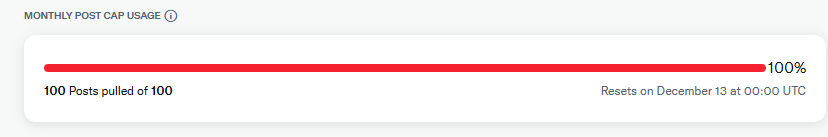

In [61]:
%pip install tweepy pandas nltk transformers translators

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [62]:
# Import the necessary libraries

import pandas as pd
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import pipeline
import json
import translators as ts  # For Google Translate
import tweepy

In [63]:
# Get the Twitter Dev Application Bearers Token
BEARER_TOKEN = "Your Twitter Dev Application Bearers Token"

No need other token like access and secret as Twitter provide a version 2 API only need Bearer token

In [64]:
# Comment out the following code as I already provide the dataset

# client = tweepy.Client(bearer_token=BEARER_TOKEN)
# query = "S&P 500 OR SP500"

# response = client.search_recent_tweets(
#     query=query,
#     max_results=100,  # Max 100 for Free tier per request
#     tweet_fields=["lang", "created_at"],
#     expansions=["author_id"],
#     user_fields=["username"],
# )

# tweets_data = [tweet.data for tweet in response.data]

# # Save the tweet data to a file
# with open("raw_twitter_response.json", "w") as f:
#     json.dump(tweets_data, f, indent=4)

The dataset is saved in 'raw_twitter_response.json'

In [65]:
nltk.download("vader_lexicon")
sid = SentimentIntensityAnalyzer()
sentiment_pipeline = pipeline("sentiment-analysis")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jacky.wong\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [66]:
# Load tweets data from JSON file
with open("raw_twitter_response.json", "r") as file:
    tweets = json.load(file)

# Create DataFrame from tweets
df = pd.DataFrame(tweets)

In [67]:
# Define a function to translate non-English text to English
def translate_to_english(text, lang):
    if lang != "en":
        try:
            return ts.translate_text(
                text, translator="google", from_language=lang, to_language="en"
            )
        except Exception as e:
            print(f"Translation error: {e}")
            return text  # Fallback to original text if translation fails
    return text


# Clean and translate tweets
def clean_and_translate_tweet(row):
    text = row["text"]
    lang = row["lang"]
    # Remove URLs, mentions, and hashtags
    text = re.sub(r"http\S+|@\w+|#\w+|\s+", " ", text).strip()
    # Translate to English if not in English
    text = translate_to_english(text, lang)
    return text

Result is saved to 'sp500_sentiment_result.json'

In [68]:
# Apply the cleaning and translation function
df["cleaned_text"] = df.apply(clean_and_translate_tweet, axis=1)

# Perform sentiment analysis with VADER and transformers on the cleaned, translated text
df["vader_sentiment"] = df["cleaned_text"].apply(
    lambda x: sid.polarity_scores(x)["compound"]
)
df["vader_label"] = df["vader_sentiment"].apply(
    lambda x: "positive" if x >= 0.05 else ("negative" if x <= -0.05 else "neutral")
)
df["transformers_sentiment"] = df["cleaned_text"].apply(
    lambda x: sentiment_pipeline(x)[0]["label"]
)

# Save the DataFrame to a JSON file for debugging
df.to_json(
    "sp500_sentiment_result.json", orient="records", lines=True, force_ascii=False
)

df

Translation error: Unsupported from_language[in] in ['aa', 'ab', 'ace', 'ach', 'af', 'ak', 'alz', 'am', 'ar', 'as', 'auto', 'av', 'awa', 'ay', 'az', 'ba', 'bal', 'ban', 'bbc', 'bci', 'be', 'bem', 'ber', 'ber-Latn', 'bew', 'bg', 'bho', 'bik', 'bm', 'bm-Nkoo', 'bn', 'bo', 'br', 'bs', 'bts', 'btx', 'bua', 'ca', 'ce', 'ceb', 'cgg', 'ch', 'chk', 'chm', 'ckb', 'cnh', 'co', 'crh', 'crh-Latn', 'crs', 'cs', 'cv', 'cy', 'da', 'de', 'din', 'doi', 'dov', 'dv', 'dyu', 'dz', 'ee', 'el', 'en', 'en-US', 'eo', 'es', 'et', 'eu', 'fa', 'fa-AF', 'ff', 'fi', 'fj', 'fo', 'fon', 'fr', 'fr-CA', 'fur', 'fy', 'ga', 'gaa', 'gd', 'gl', 'gn', 'gom', 'gu', 'gv', 'ha', 'haw', 'hi', 'hil', 'hmn', 'hr', 'hrx', 'ht', 'hu', 'hy', 'iba', 'id', 'ig', 'ilo', 'is', 'it', 'iu', 'iu-Latn', 'iw', 'ja', 'jam', 'jw', 'ka', 'kac', 'kek', 'kg', 'kha', 'kk', 'kl', 'km', 'kn', 'ko', 'kr', 'kri', 'ktu', 'ku', 'kv', 'ky', 'la', 'lb', 'lg', 'li', 'lij', 'lmo', 'ln', 'lo', 'lt', 'ltg', 'lua', 'luo', 'lus', 'lv', 'mad', 'mai', 'mak', 'ma

,text,created_at,author_id,edit_history_tweet_ids,id,lang,cleaned_text,vader_sentiment,vader_label,transformers_sentiment
0,@sayu2_sp500 …もしかして今騒いでる購入詐欺への対応とか関係してるのかな…💦💦,2024-11-14T02:20:55.000Z,974118514742124544,[1856884990879174858],1856884990879174858,ja,… Maybe it's related to the response to purcha...,-0.5859,negative,NEGATIVE
1,RT @Eexitliquidity: Choose the Meme\n\n#SPX690...,2024-11-14T02:20:51.000Z,1817103660343844864,[1856884972604239900],1856884972604239900,en,RT : Choose the Meme -&gt; feed Murad and m...,0.4902,positive,NEGATIVE
2,"RT @techconcatalina: 🔥BOMBAZO🔥\n\n💥#Coinbase, ...",2024-11-14T02:20:42.000Z,2912244935,[1856884933295255555],1856884933295255555,es,"RT: 🔥Bombazo🔥 💥, in association with Vaneck, l...",0.1280,positive,NEGATIVE
3,RT @Cosmos_Airdrops: $ATOM and $INJ are now pa...,2024-11-14T02:20:38.000Z,1486012406090412033,[1856884918434807840],1856884918434807840,en,RT : $ATOM and $INJ are now part of Coinbase’...,0.0000,neutral,NEGATIVE
4,RT @Eexitliquidity: Choose the Meme\n\n#SPX690...,2024-11-14T02:20:34.000Z,1800546177605066752,[1856884900655231309],1856884900655231309,en,RT : Choose the Meme -&gt; feed Murad and m...,0.4902,positive,NEGATIVE
...,...,...,...,...,...,...,...,...,...,...
85,@littlemustacho #SP500 \n\nCa: 8BqRWDrRK8NfMCZ...,2024-11-14T01:54:53.000Z,1829382082469961728,[1856878440118358046],1856878440118358046,pl,Ca: 8BQRWDRRK8NFMczWPMFSDFTOWHT7BW995A4HDGPPUMP,0.0000,neutral,NEGATIVE
86,ग्लोबल बाजारों से सुस्त संकेत\n\nसीमित दायरे म...,2024-11-14T01:54:47.000Z,819072731853438976,[1856878411786117530],1856878411786117530,hi,Global markets dull signal in limited range cl...,-0.5574,negative,NEGATIVE
87,RT @Reuters: The Dow and the S&amp;P 500 ended...,2024-11-14T01:54:30.000Z,1377761386340696064,[1856878340067524782],1856878340067524782,en,RT : The Dow and the S&amp;P 500 ended slight...,-0.3182,negative,NEGATIVE
88,RT @MichaelMOTTCM: S&amp;P 500 equal weight vs...,2024-11-14T01:54:26.000Z,1368639540676599811,[1856878323164668017],1856878323164668017,en,RT : S&amp;P 500 equal weight vs 2024 and 202...,-0.5106,negative,NEGATIVE


## 1. Load Twitter Sentiment Data

* As we are using free APIs, we cannot get full dataset. So we find some small dataset from online.

* Load the twitter sentiment dataset, set the index, calculat engagement ratio and filter out stocks with no significant twitter activity.

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import os
plt.style.use('ggplot')

sentiment_df = pd.read_csv(os.path.join('sentiment_data.csv'))

sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

sentiment_df = sentiment_df.set_index(['date', 'symbol'])

sentiment_df['engagement_ratio'] = sentiment_df['twitterComments']/sentiment_df['twitterLikes']

sentiment_df = sentiment_df[(sentiment_df['twitterLikes']>20)&(sentiment_df['twitterComments']>10)]

sentiment_df

twitterPosts  twitterComments  twitterLikes  \
date       symbol                                                
2021-11-18 AAPL             811             2592         21674   
           AMD              150              675          2949   
           AMZN             557             1315         12969   
           ATVI              82               36           131   
           BA                61               55           342   
...                         ...              ...           ...   
2023-01-04 T                184             3409         14271   
           TSLA            6767           540711       3810688   
           TSN               35              168           460   
           V                132             1008          5943   
           XOM              212              374          2071   

                   twitterImpressions  twitterSentiment  engagement_ratio  
date       symbol                                                          
2021-11-18 AAPL               7981808               NaN          0.119590  
           AMD                1645270               NaN          0.228891  
           AMZN               5590695               NaN          0.101396  
           ATVI               1310715               NaN          0.274809  
           BA                  425847               NaN          0.160819  
...                               ...               ...               ...  
2023-01-04 T                   884935          0.590457          0.238876  
           TSLA              55464921          0.543057          0.141893  
           TSN                  57207          0.561900          0.365217  
           V                   139835          0.567286          0.169611  
           XOM                 483389          0.588914          0.180589  

[25375 rows x 6 columns]

## 2. Aggregate Monthly and calculate average sentiment for the month

* Aggregate on a monthly level and calculate average monthly metric, for the one we choose.

In [70]:
aggragated_df = (sentiment_df.reset_index('symbol').groupby([pd.Grouper(freq='M'), 'symbol'])
                    [['engagement_ratio']].mean())

aggragated_df['rank'] = (aggragated_df.groupby(level=0)['engagement_ratio']
                         .transform(lambda x: x.rank(ascending=False)))

aggragated_df

engagement_ratio  rank
date       symbol                        
2021-11-30 AAL             0.203835  37.0
           AAPL            0.256318  23.0
           ABBV            0.244677  26.0
           ABT             0.313368  14.0
           AES             0.864613   2.0
...                             ...   ...
2023-01-31 TMO             0.333313  19.0
           TSLA            0.151992  72.0
           TSN             0.280553  30.0
           V               0.194045  60.0
           XOM             0.217904  53.0

[1109 rows x 2 columns]

## 3. Select Top 5 Stocks based on their cross-sectional ranking for each month

* Select top 5 stocks by rank for each month and fix the date to start at beginning of next month.

In [71]:
filtered_df = aggragated_df[aggragated_df['rank']<6].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'symbol'])

filtered_df.head(20)

engagement_ratio  rank
date       symbol                        
2021-12-01 AES             0.864613   2.0
           FCX             0.626323   5.0
           MNST            0.699721   3.0
           OXY             2.147741   1.0
           SLB             0.647374   4.0
2022-01-01 D               0.801994   5.0
           FCX             0.841220   4.0
           L               6.507246   1.0
           LUV             1.303215   2.0
           MA              0.883401   3.0
2022-02-01 AMD             0.715556   4.0
           D               1.136678   1.0
           FCX             0.655237   5.0
           LUV             1.035258   2.0
           MA              0.729063   3.0
2022-03-01 FCX             1.138332   2.0
           GILD            0.530886   5.0
           LUV             1.574377   1.0
           MRO             0.581748   4.0
           OXY             1.025579   3.0

## 4. Extract the stocks to form portfolios with at the start of each new month

* Create a dictionary containing start of month and corresponded selected stocks.

In [72]:
dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2021-12-01': ['AES', 'FCX', 'MNST', 'OXY', 'SLB'],
 '2022-01-01': ['D', 'FCX', 'L', 'LUV', 'MA'],
 '2022-02-01': ['AMD', 'D', 'FCX', 'LUV', 'MA'],
 '2022-03-01': ['FCX', 'GILD', 'LUV', 'MRO', 'OXY'],
 '2022-04-01': ['A', 'CRM', 'PFE', 'PM', 'STZ'],
 '2022-05-01': ['AMD', 'CRM', 'CVX', 'J', 'KEY'],
 '2022-06-01': ['AMD', 'DD', 'FCX', 'KEY', 'LMT'],
 '2022-07-01': ['CB', 'CRM', 'DD', 'FCX', 'STZ'],
 '2022-08-01': ['A', 'DD', 'JPM', 'REGN', 'STZ'],
 '2022-09-01': ['ABT', 'DIS', 'L', 'META', 'MRNA'],
 '2022-10-01': ['J', 'KEY', 'L', 'META', 'MU'],
 '2022-11-01': ['A', 'DD', 'FCX', 'J', 'META'],
 '2022-12-01': ['AEP', 'AES', 'DD', 'J', 'STZ'],
 '2023-01-01': ['A', 'AES', 'DAL', 'J', 'KEY'],
 '2023-02-01': ['A', 'AES', 'BIIB', 'FCX', 'MDT']}

## 5. Download fresh stock prices for only selected/shortlisted stocks

In [73]:
stocks_list = sentiment_df.index.get_level_values('symbol').unique().tolist()

if USE_BACKUP is True:
    prices_df = pd.read_pickle("data5.pkl")
else:
    prices_df = yf.download(tickers=stocks_list,
                            start='2021-01-01',
                            end='2023-03-01')

if BACKUP_DATA is True:
    prices_df.to_pickle("data5.pkl")

prices_df.index = prices_df.index.tz_localize(None).normalize()

copy1 = prices_df.copy()
prices_df

Price        Adj Close                                                         \
Ticker               A    AAL         AAP        AAPL        ABBV         ABT   
Date                                                                            
2021-01-04  115.796394  15.13  144.788589  126.683426   90.489502  102.054939   
2021-01-05  116.743141  15.43  144.632187  128.249741   91.425217  103.317650   
2021-01-06  119.944519  15.52  152.987808  123.932640   90.635445  103.102524   
2021-01-07  123.136154  15.38  154.294540  128.161636   91.605499  104.103340   
2021-01-08  124.014572  15.13  156.493866  129.267807   92.086220  104.393295   
...                ...    ...         ...         ...         ...         ...   
2023-02-22  140.342041  15.56  139.062637  147.747726  142.166794   99.620407   
2023-02-23  141.448349  15.87  137.503738  148.233887  143.487778   99.484596   
2023-02-24  139.472809  15.56  134.444000  145.564941  144.091660   97.457062   
2023-02-27  140.440796  15.63  136.167526  146.765442  145.573029   96.787682   
2023-02-28  140.233383  15.98  140.360123  146.259445  145.214493   98.679405   

Price                                                    ...   Volume  \
Ticker            AEP        AES         ALB        AMD  ...      RCL   
Date                                                     ...            
2021-01-04  70.949341  20.735624  147.418106  92.300003  ...  5732800   
2021-01-05  70.853615  21.431568  157.366379  92.769997  ...  4029500   
2021-01-06  71.419205  22.288115  169.120819  90.330002  ...  3612500   
2021-01-07  69.513641  22.065060  177.716858  95.160004  ...  3993700   
2021-01-08  68.895866  22.680704  177.813492  94.580002  ...  3104200   
...               ...        ...         ...        ...  ...      ...   
2023-02-22  85.452385  24.015274  241.536987  76.610001  ...  2044600   
2023-02-23  85.348892  24.015274  248.789474  79.750000  ...  2066600   
2023-02-24  85.085442  23.949064  244.545807  78.089996  ...  2875100   
2023-02-27  84.746719  23.532883  251.896286  78.769997  ...  2459700   
2023-02-28  82.770836  23.343718  249.240280  78.580002  ...  3662300   

Price                                                                          \
Ticker         REGN       SLB      STZ         T      TMO       TSLA      TSN   
Date                                                                            
2021-01-04   911100   8743400  1202600  86700816  2220400  145914600  2177400   
2021-01-05   797700  16256600  1530200  83054520  2046700   96735600  2297100   
2021-01-06  1434700  19456300  1861700  73455520  2112300  134100000  1942200   
2021-01-07  1126600  14502400  2537100  71265359  2144400  154496700  2969400   
2021-01-08  1018800  11951900  1595400  72471656  2221700  225166500  2672400   
...             ...       ...      ...       ...      ...        ...      ...   
2023-02-22   415500   9181100  1092200  25308800  1705300  191828500  4217700   
2023-02-23   553300   6324500   979700  24845800  1160200  146360000  3403500   
2023-02-24   525900   8458700   702900  29138100   852600  142228100  2439300   
2023-02-27   557100   6287000   608200  22981100  1110600  161028300  3922200   
2023-02-28   622700  10634200  1136900  34154800  1188800  153144900  3556300   

Price                           
Ticker             V       XOM  
Date                            
2021-01-04  10318300  27764700  
2021-01-05   6869700  44035100  
2021-01-06   7206200  36484800  
2021-01-07  10967900  29528100  
2021-01-08   6513000  28628200  
...              ...       ...  
2023-02-22   4621800  13973800  
2023-02-23   5533800  11289400  
2023-02-24   4414400  14351000  
2023-02-27   4255300  11710500  
2023-02-28   5385400  18107000  

[542 rows x 510 columns]

## 6. Calculate Portfolio Returns with monthly rebalancing


In [74]:
prices_df = copy1.copy()


returns_df = np.log(prices_df["Adj Close"]).diff()

portfolio_df = pd.DataFrame()


for start_date in fixed_dates.keys():
    end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd()).strftime('%Y-%m-%d')
    cols = fixed_dates[start_date]
    temp_df = returns_df[start_date:end_date][cols].mean(axis=1).to_frame('portfolio_return')
    portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

portfolio_df

,portfolio_return
Date,
2021-12-01,-0.016417
2021-12-02,0.024872
2021-12-03,-0.007711
2021-12-06,0.023926
2021-12-07,0.030547
...,...
2023-02-22,-0.007870
2023-02-23,-0.007323
2023-02-24,-0.009463


## 7. Download NASDAQ/QQQ prices and calculate returns to compare to our strategy

In [75]:
if USE_BACKUP is True:
    qqq_df = pd.read_pickle("data6.pkl")
else:
    qqq_df = yf.download(tickers='QQQ',
                         start='2021-01-01',
                         end='2023-03-01')

if BACKUP_DATA is True:
    qqq_df.to_pickle("data6.pkl")

qqq_ret = np.log(qqq_df['Adj Close']).diff().to_frame('nasdaq_return')

portfolio_df = portfolio_df.merge(qqq_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

,portfolio_return,nasdaq_return
Date,,
2021-12-01,-0.016417,-0.017159
2021-12-02,0.024872,0.007181
2021-12-03,-0.007711,-0.017542
2021-12-06,0.023926,0.007981
2021-12-07,0.030547,0.029669
...,...,...
2023-02-22,-0.007870,0.000748
2023-02-23,-0.007323,0.008696
2023-02-24,-0.009463,-0.016886


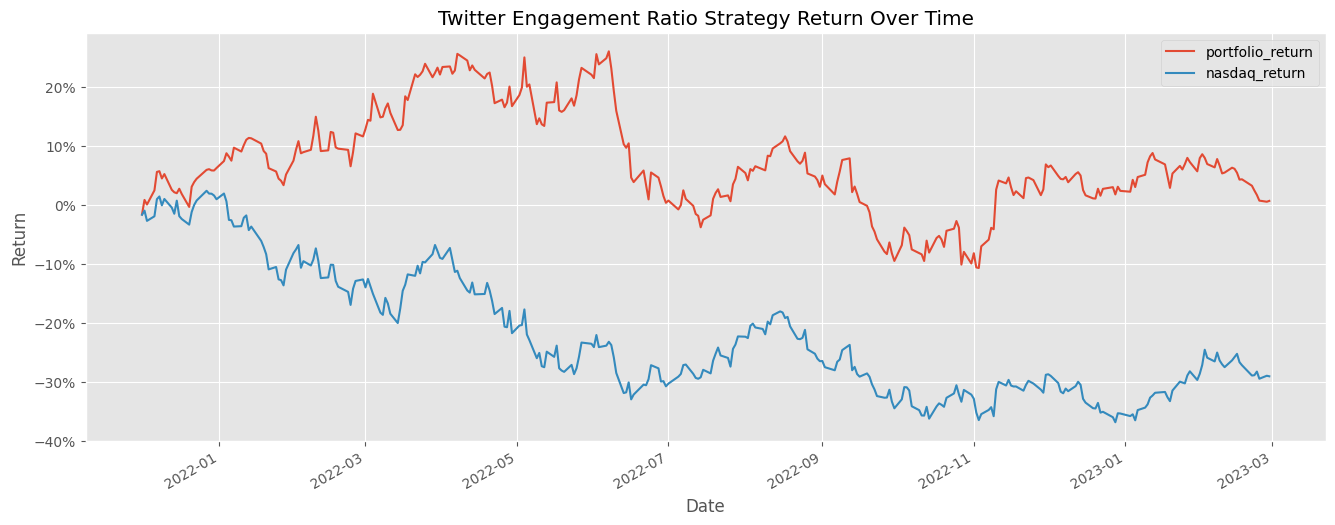

In [76]:
portfolios_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()).sub(1)

portfolios_cumulative_return.plot(figsize=(16,6))

plt.title('Twitter Engagement Ratio Strategy Return Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()

Calculculate the annualized volatility of the portfolio

In [77]:
vol = portfolio_df.var(axis=0).dropna()**0.5
vol_annnualized = vol * 252**0.5
vol_annnualized

portfolio_return    0.284572
nasdaq_return       0.307309
dtype: float64

Calculate the Sharp Ratio of the portfolios over the period

In [78]:
sharp = portfolios_cumulative_return.iloc[-1] / vol_annnualized
sharp

portfolio_return    0.022403
nasdaq_return      -0.946547
dtype: float64